In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [115]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [116]:
fsd = "first_submission_date"
families = df["family"].unique()

variances = []
for family in families:
    variances.append(np.var(df[df["family"] == family][fsd]))

df_variances = pd.DataFrame({"family": families, "variance": variances})
df_variances = df_variances.sort_values(by="variance", ascending=True)

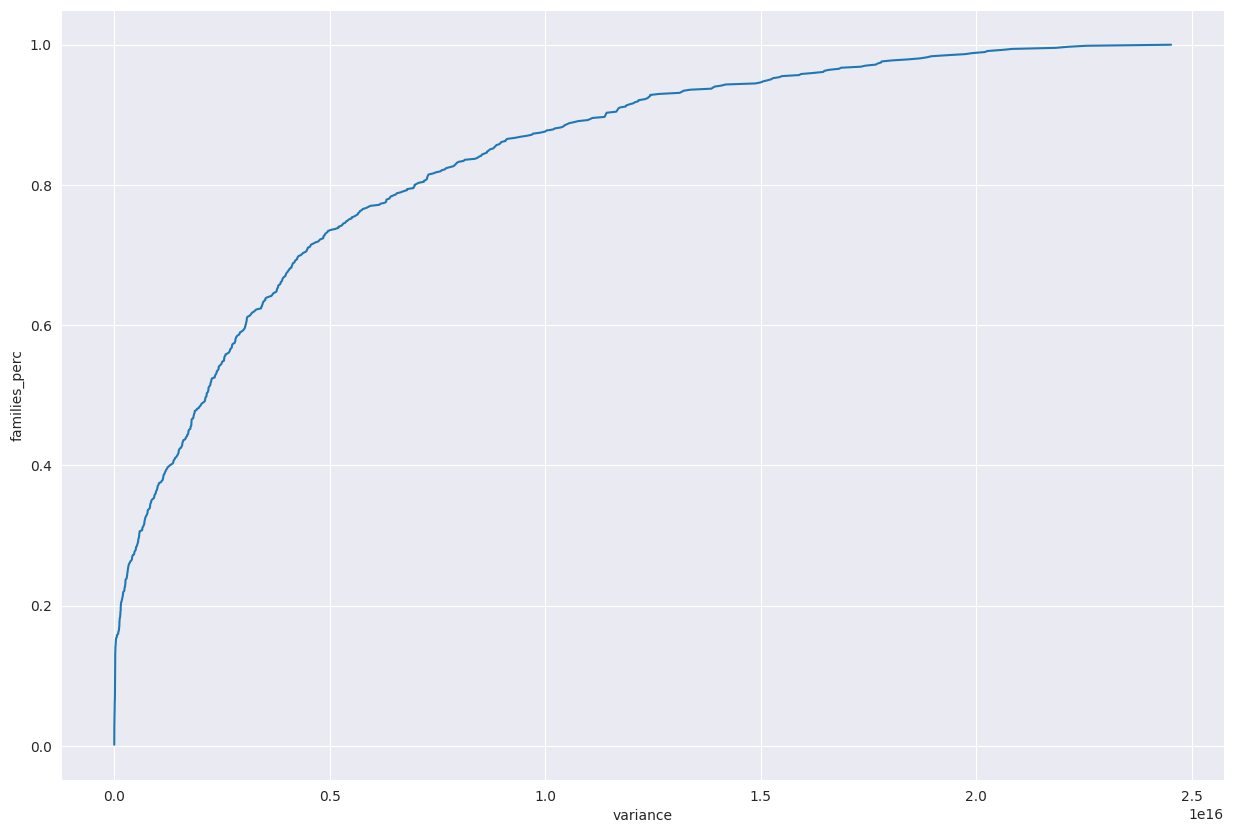

In [117]:
df_variances['families_perc'] = df_variances["variance"].apply(
    lambda t: len(df_variances[df_variances["variance"] <= t]) / len(families)
)

# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
sns.lineplot(df_variances, x="variance", y="families_perc")
plt.show()

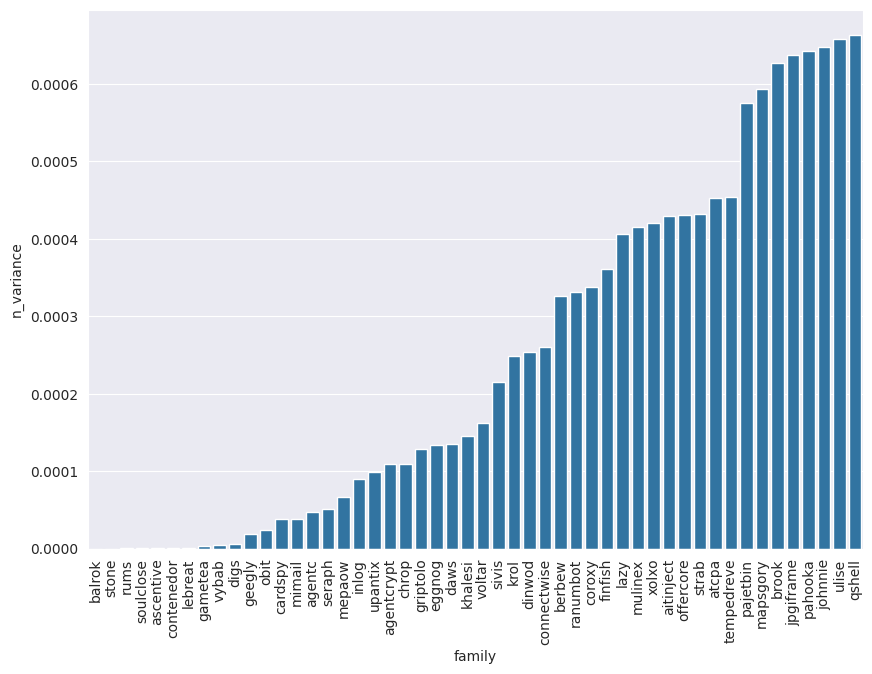

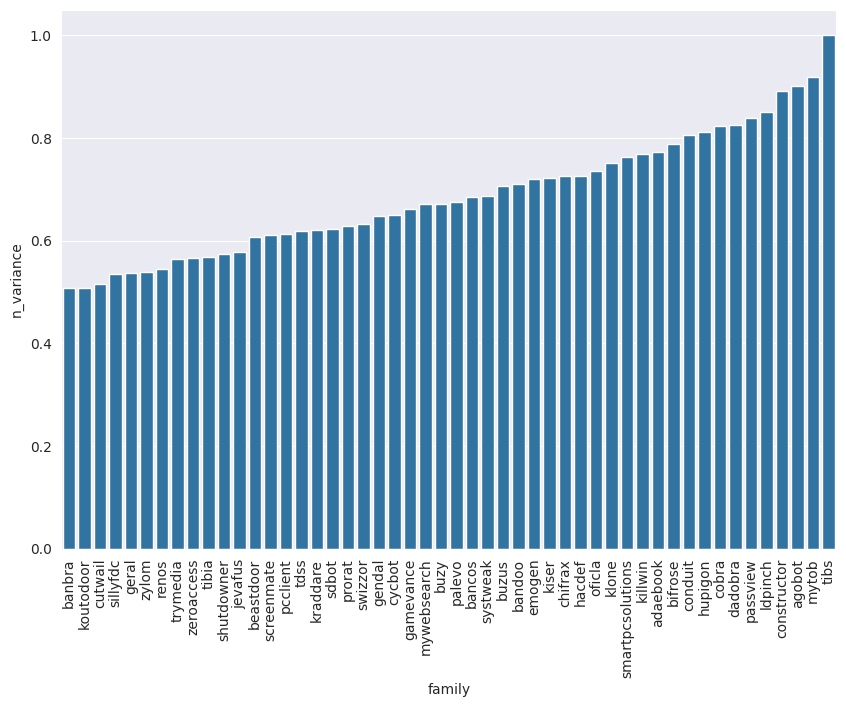

In [118]:
v_max = df_variances["variance"].max()
df_variances["n_variance"] = df_variances["variance"].apply(lambda v: v / v_max)

plt.figure(figsize=(10, 7))
sns.barplot(data=df_variances.head(50), x="family", y="n_variance")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 7))
sns.barplot(data=df_variances.tail(50), x="family", y="n_variance")
plt.xticks(rotation=90)
plt.show()

In [127]:
def timestamp_to_datetime(t):
    return pd.to_datetime(t, unit="s")


def timestamp_to_month_year(t):
    dt = timestamp_to_datetime(t)
    return pd.Timestamp(f"{dt.year}-{dt.month}-01")

def plot(df_plot, family, family_variance, family_timespan, t_min, t_max):
    plt.figure(figsize=(20, 10))
    plt.title(f"Family: {family}, Variance: {family_variance}\n"
              f"Timespan in months: {family_timespan}\n"
              f"Range: {t_min} - {t_max}")
    plt.xticks(rotation=90)
    sns.barplot(data=df_plot, x="month", y="count")
    plt.show()
    
 # Min and maximum months
min_month = timestamp_to_month_year(df[fsd].min())
max_month = timestamp_to_month_year(df[fsd].max())

def plot_family_distribution(df_split):
    for family in df_split["family"]:
        
        df_fam = df[df["family"] == family]
        df_fam_month = pd.DataFrame({
            "family": df_fam["family"],
            "month": df_fam[fsd].map(lambda t: timestamp_to_month_year(t))
        })
        df_fam_month = df_fam_month.groupby(by="month").size().reset_index(name="count")
    
        # Get all the days between min and max
        months_range = pd.date_range(start=min_month, end=max_month, freq='MS').tolist()
    
        # Put to 0 each month when there are no submissions 
        counts = np.zeros(len(months_range))
        idxs = [months_range.index(m) for m in df_fam_month["month"]]
        counts[idxs] = df_fam_month["count"]
    
        # Compute the timespan and the number of months with missing values
        t_max = timestamp_to_datetime(df_fam[fsd].max())
        t_min = timestamp_to_datetime(df_fam[fsd].min())
        family_timespan = (int((t_max - t_min) / np.timedelta64(1, 'M')))
        family_variance = df_variances[df_variances["family"] == family]["n_variance"].iloc[0]
        df_plot = pd.DataFrame({"month": months_range, "count": counts})

        plot(df_plot, family, family_variance, family_timespan, t_min, t_max)
        

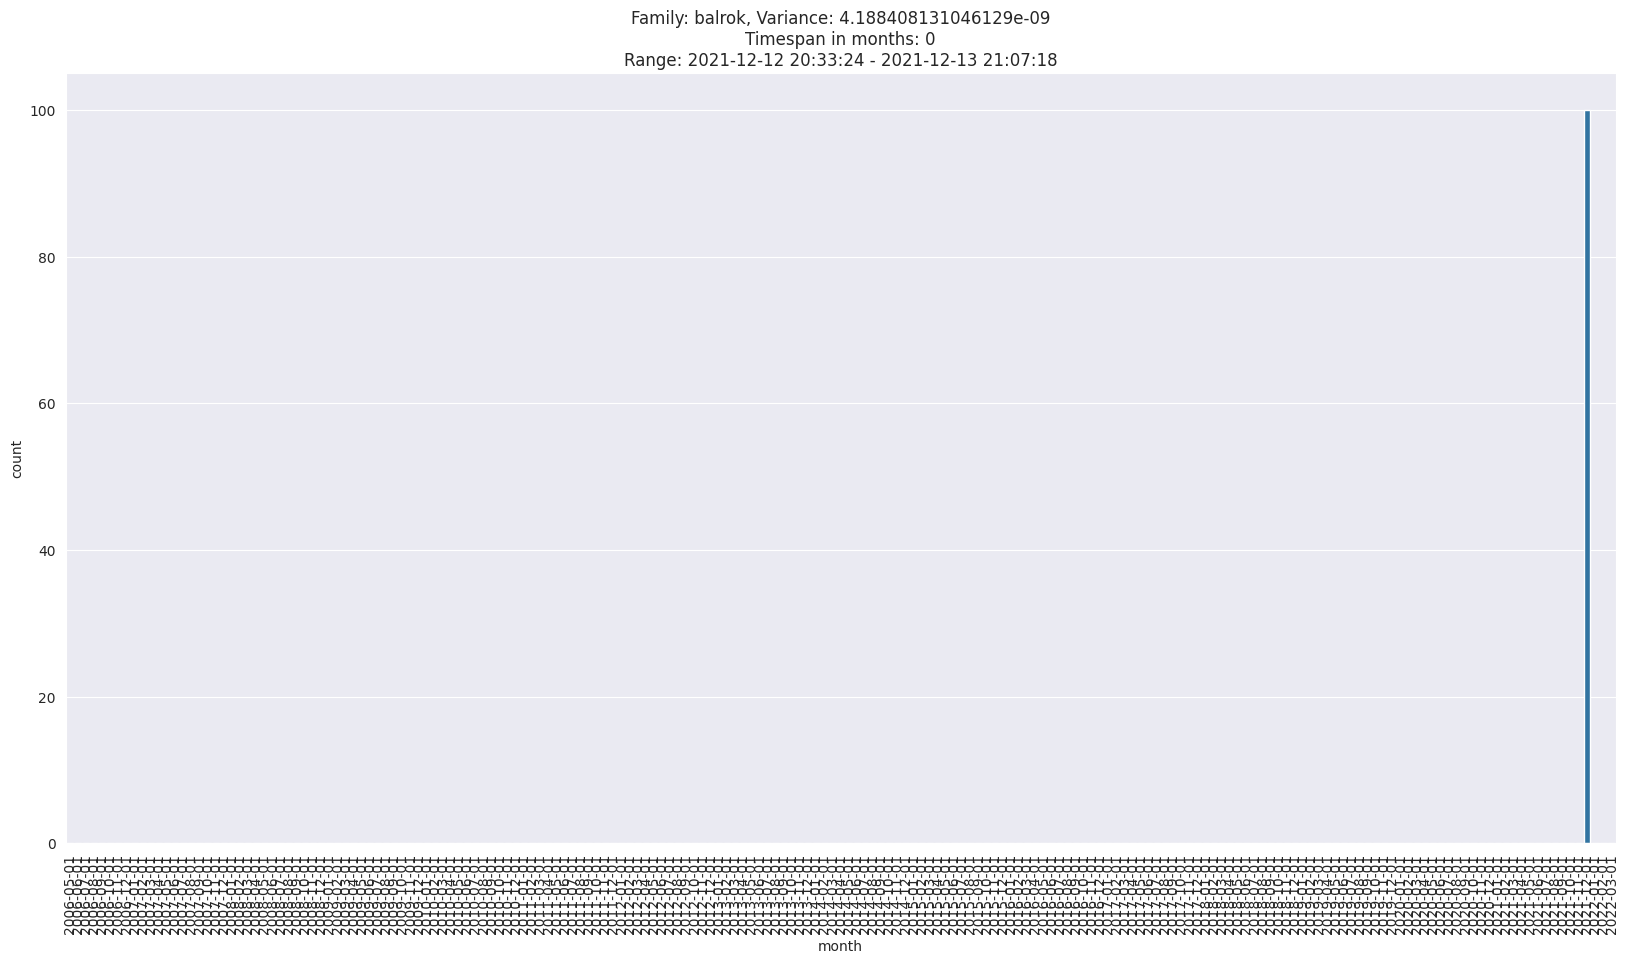

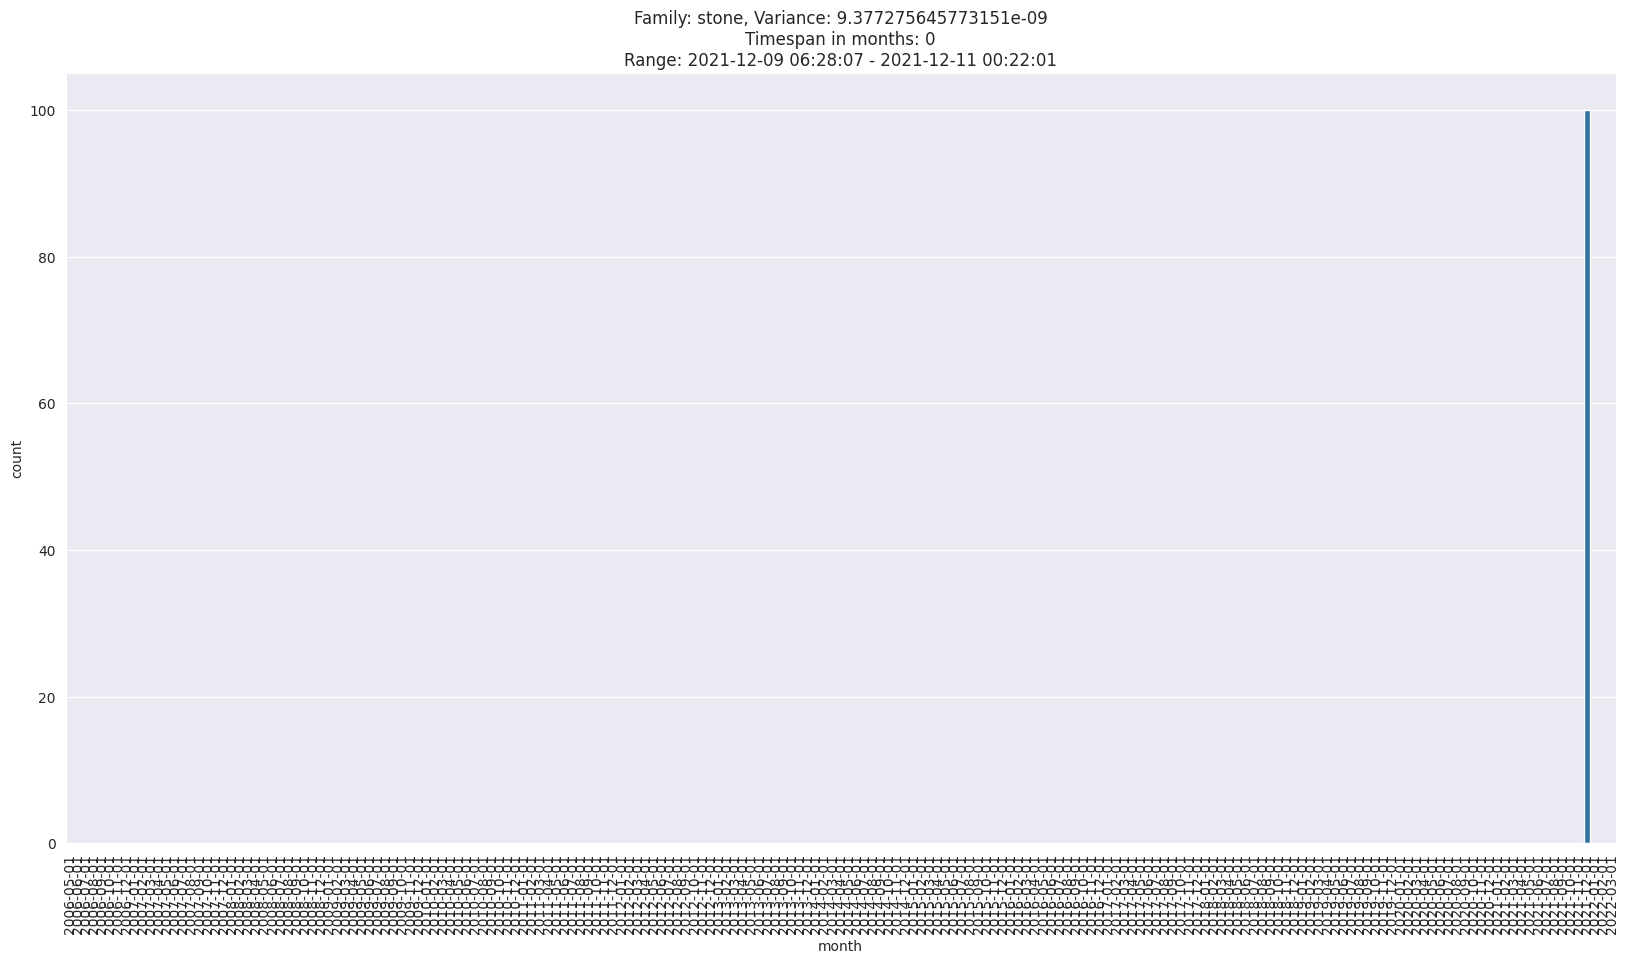

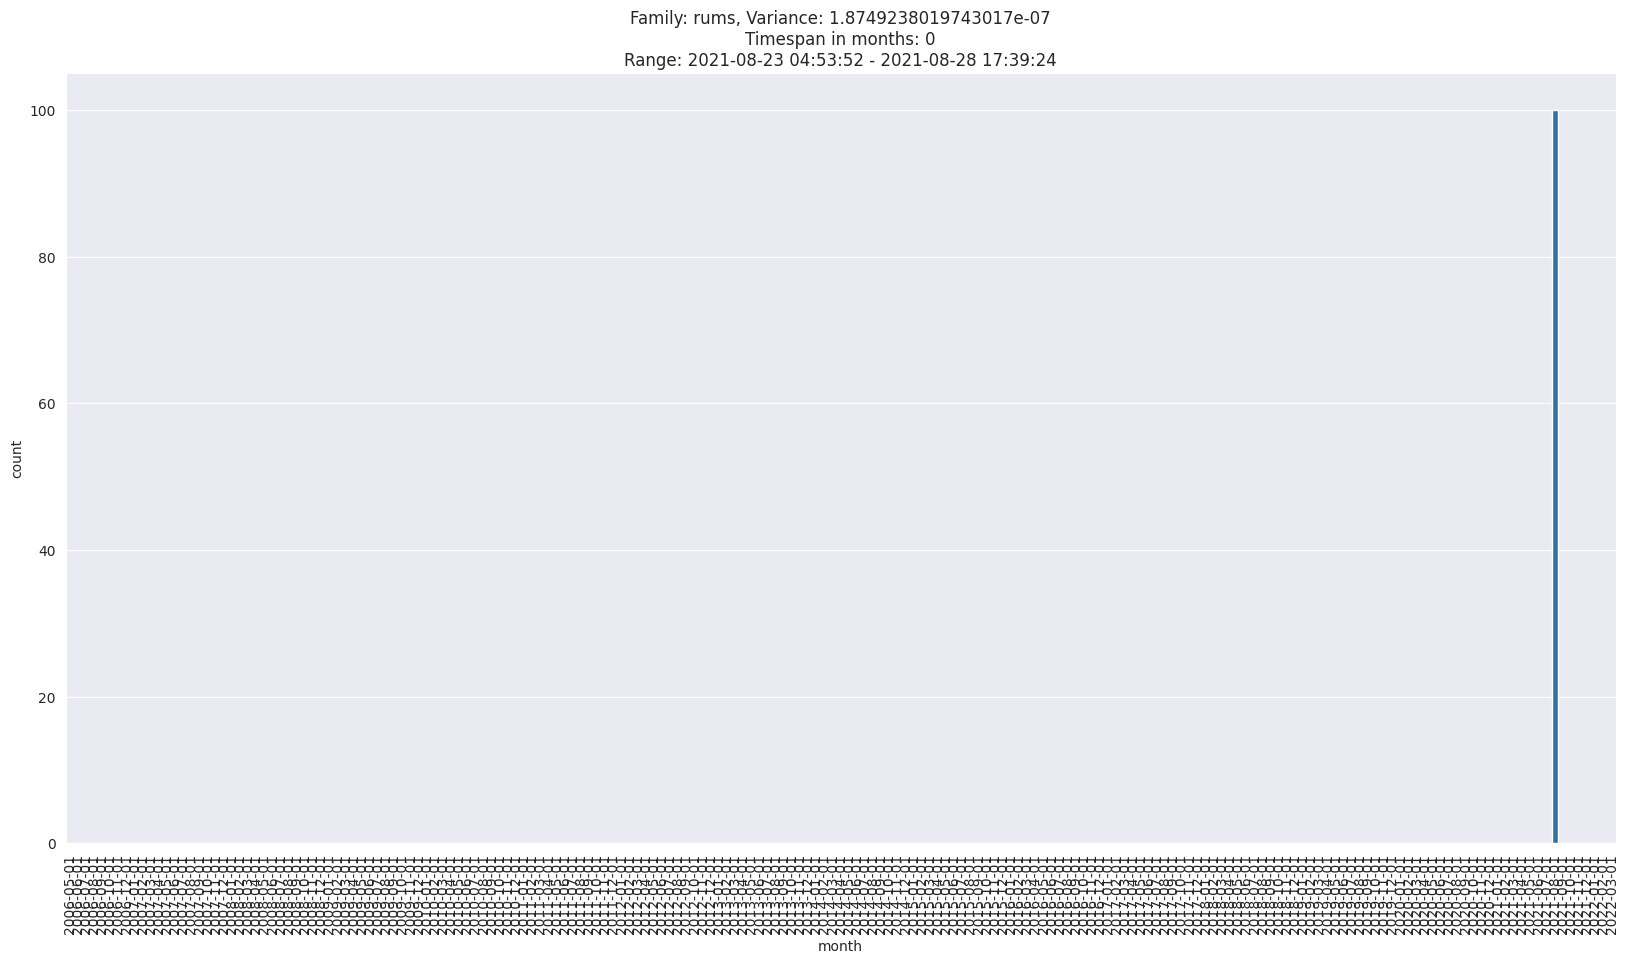

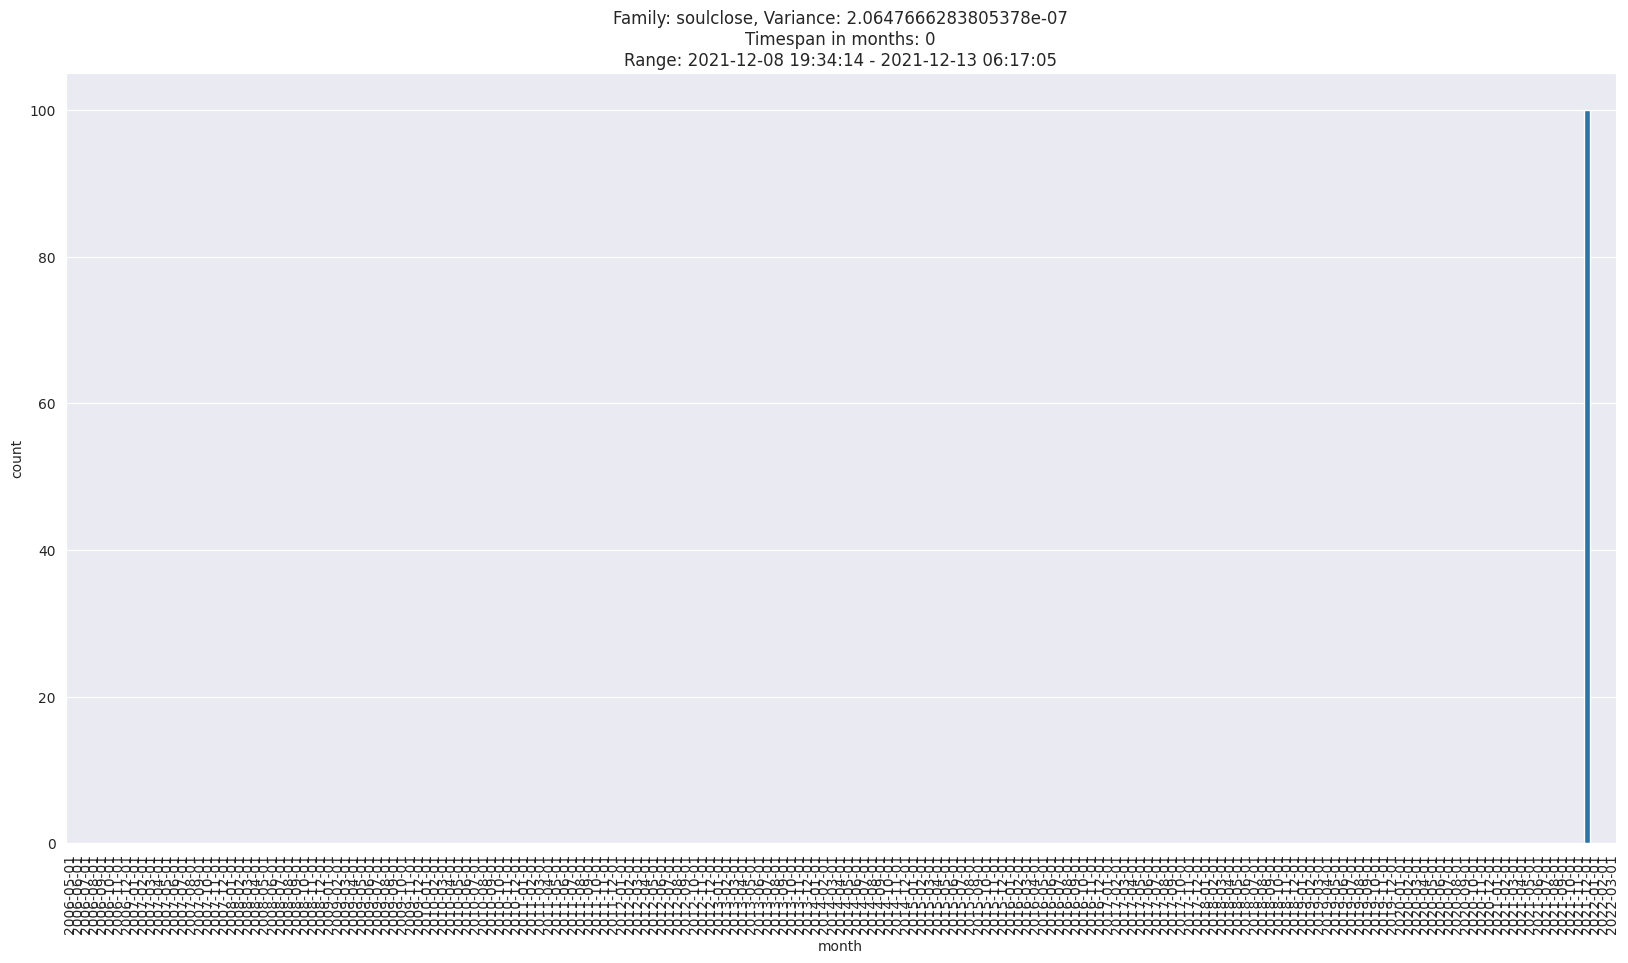

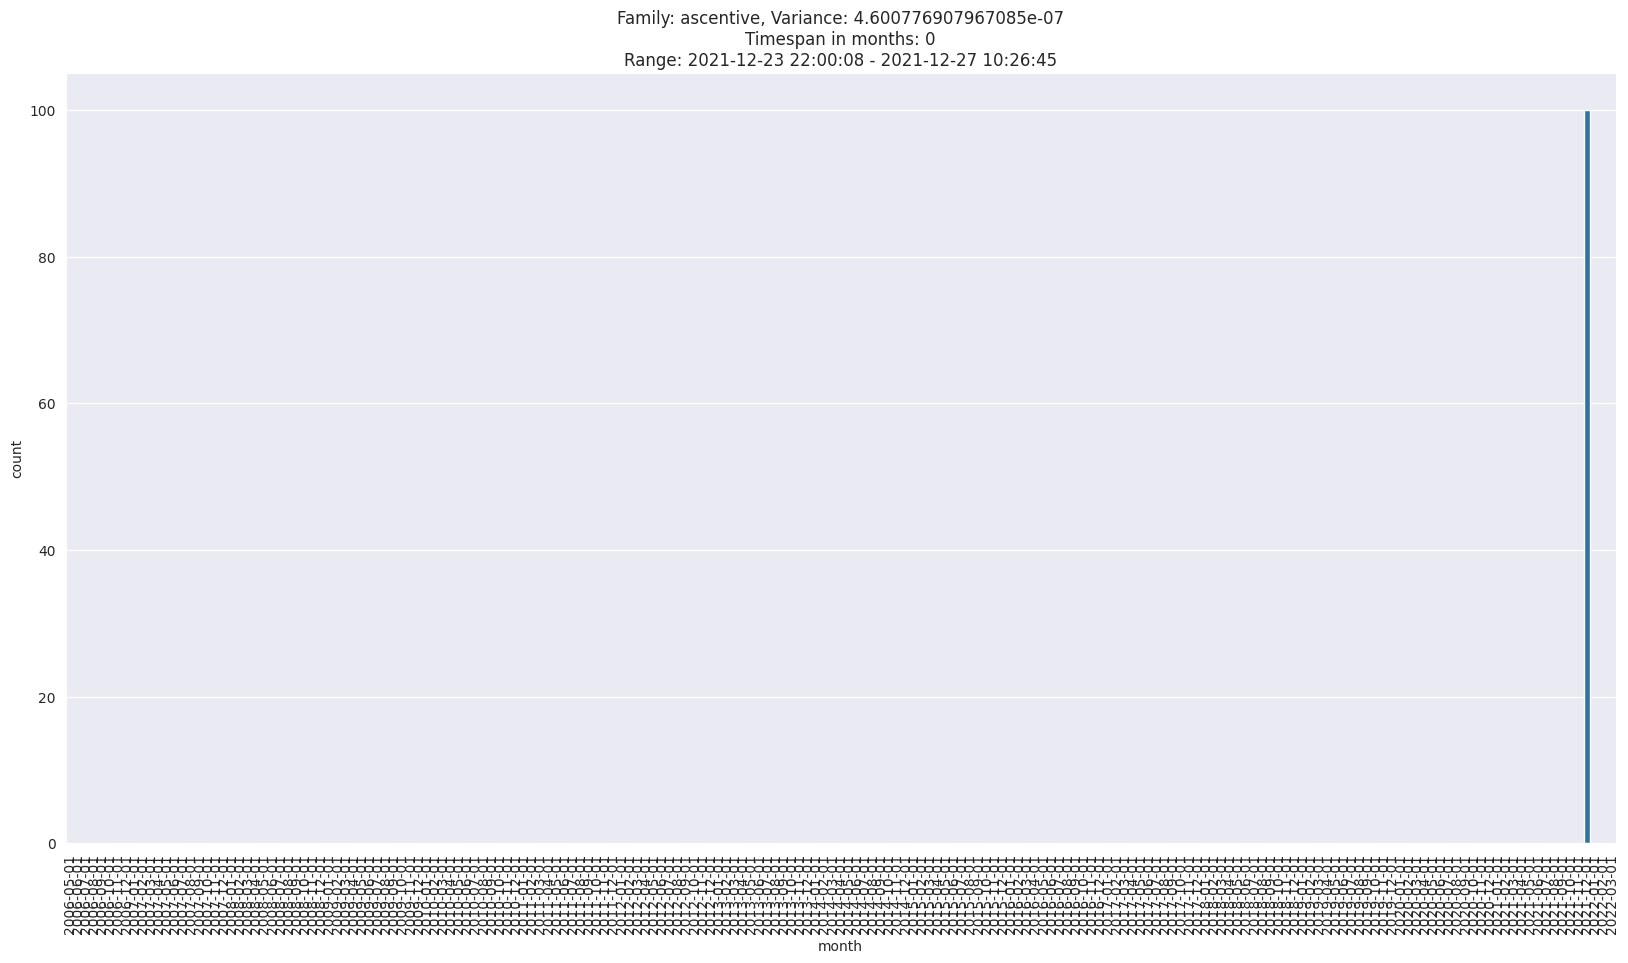

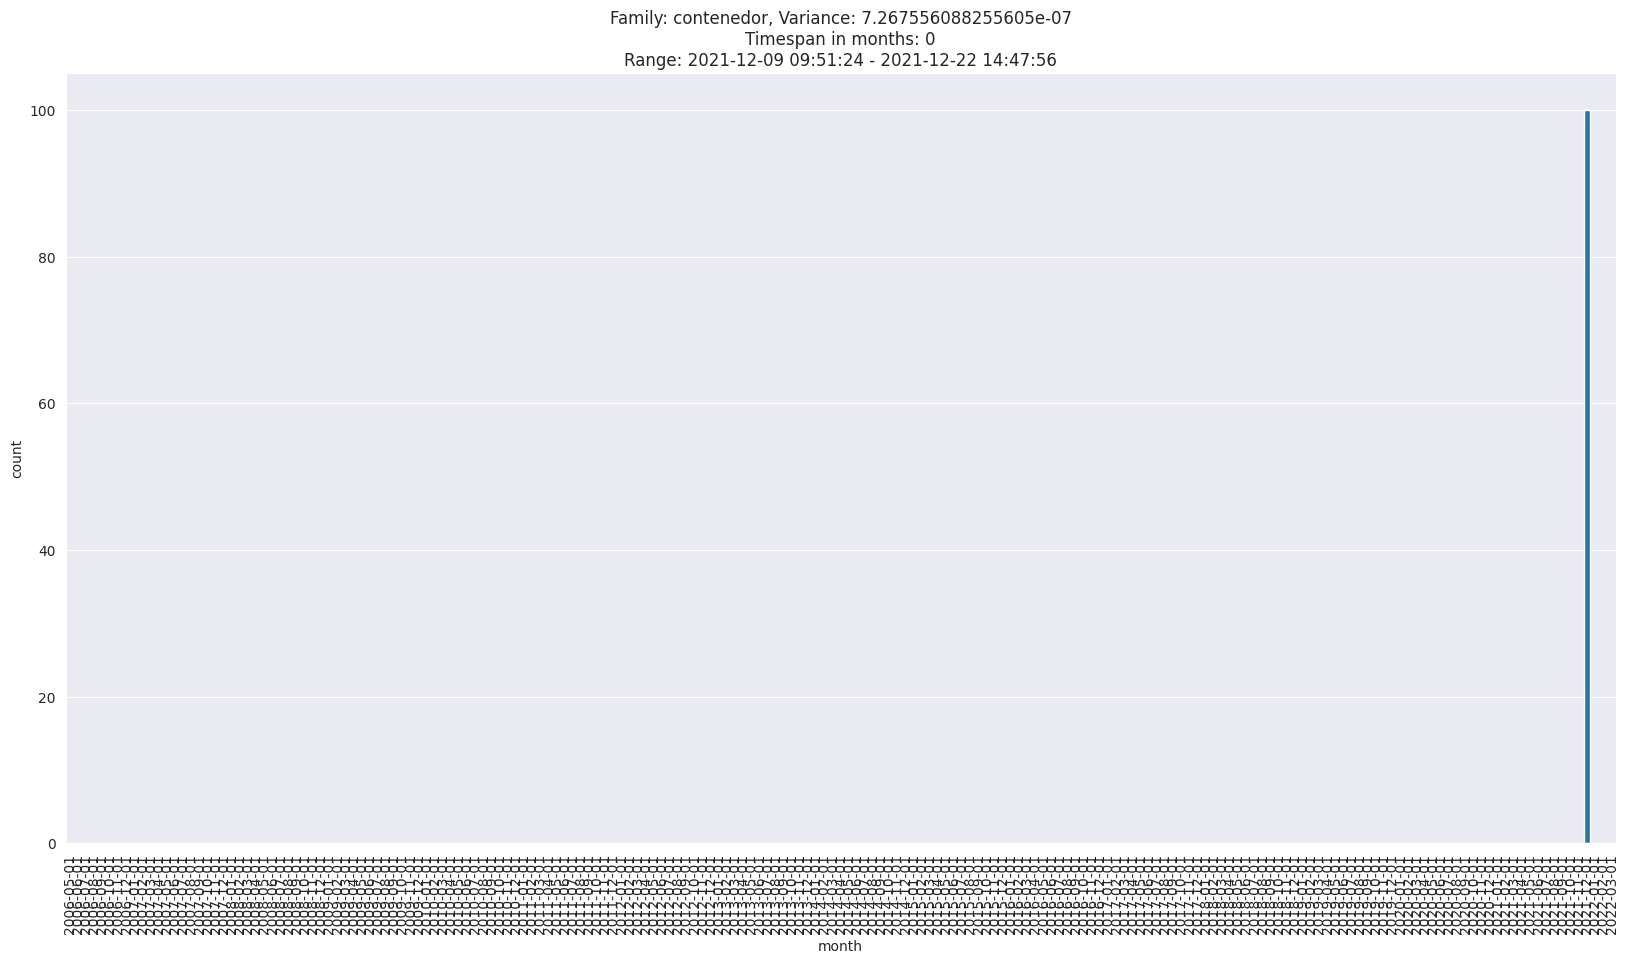

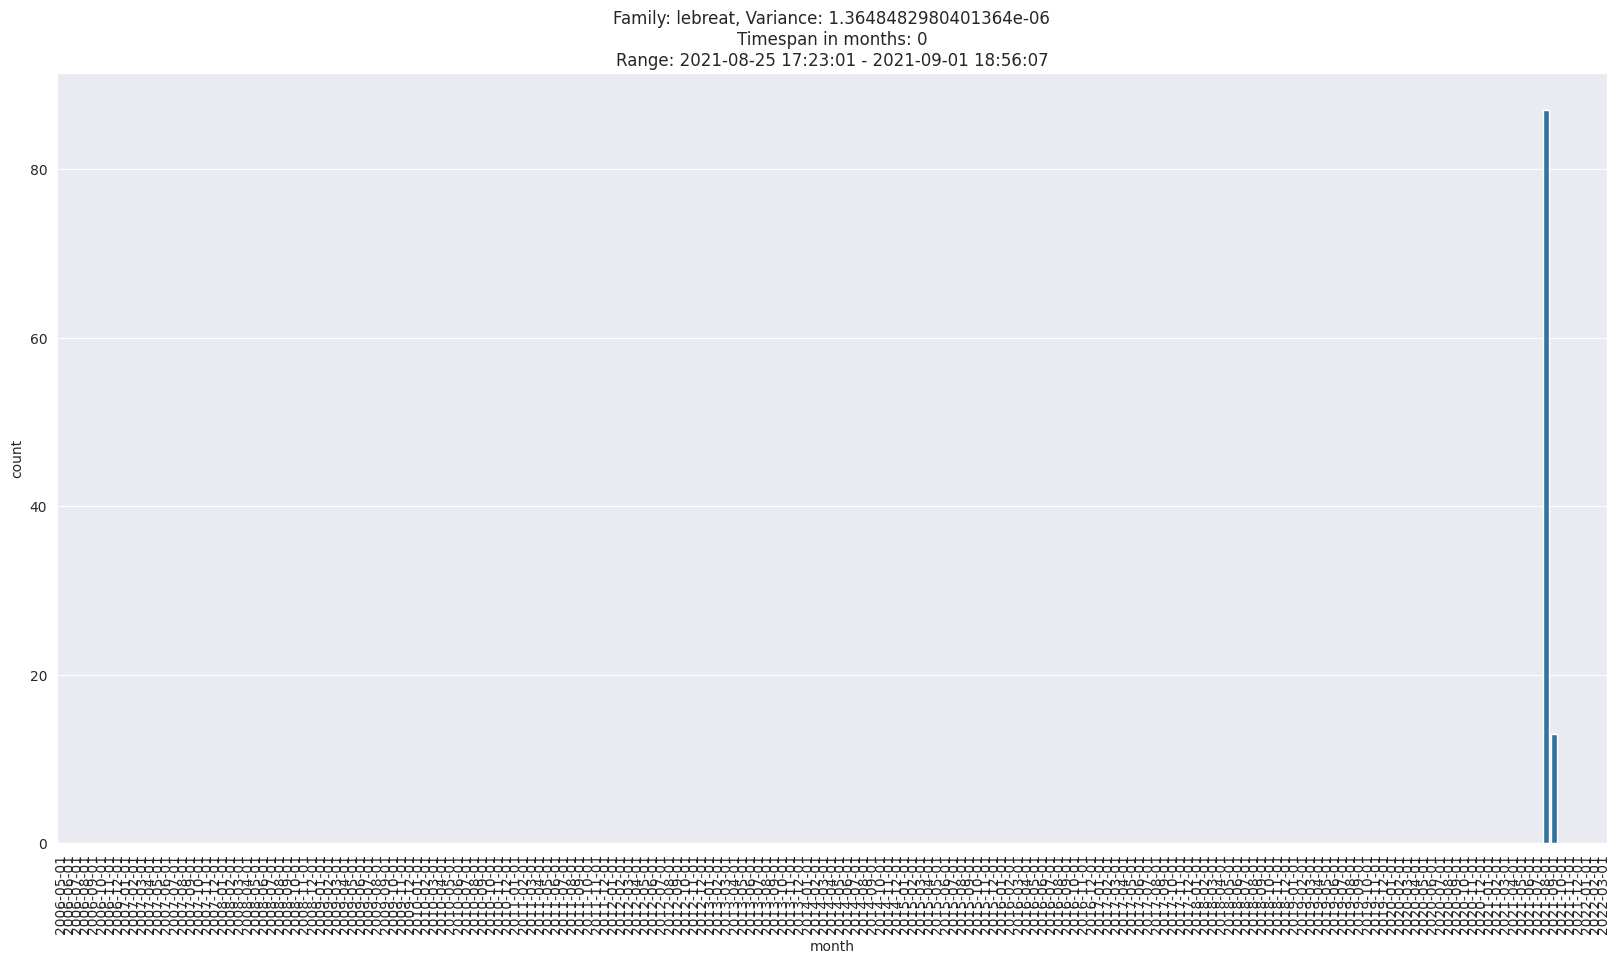

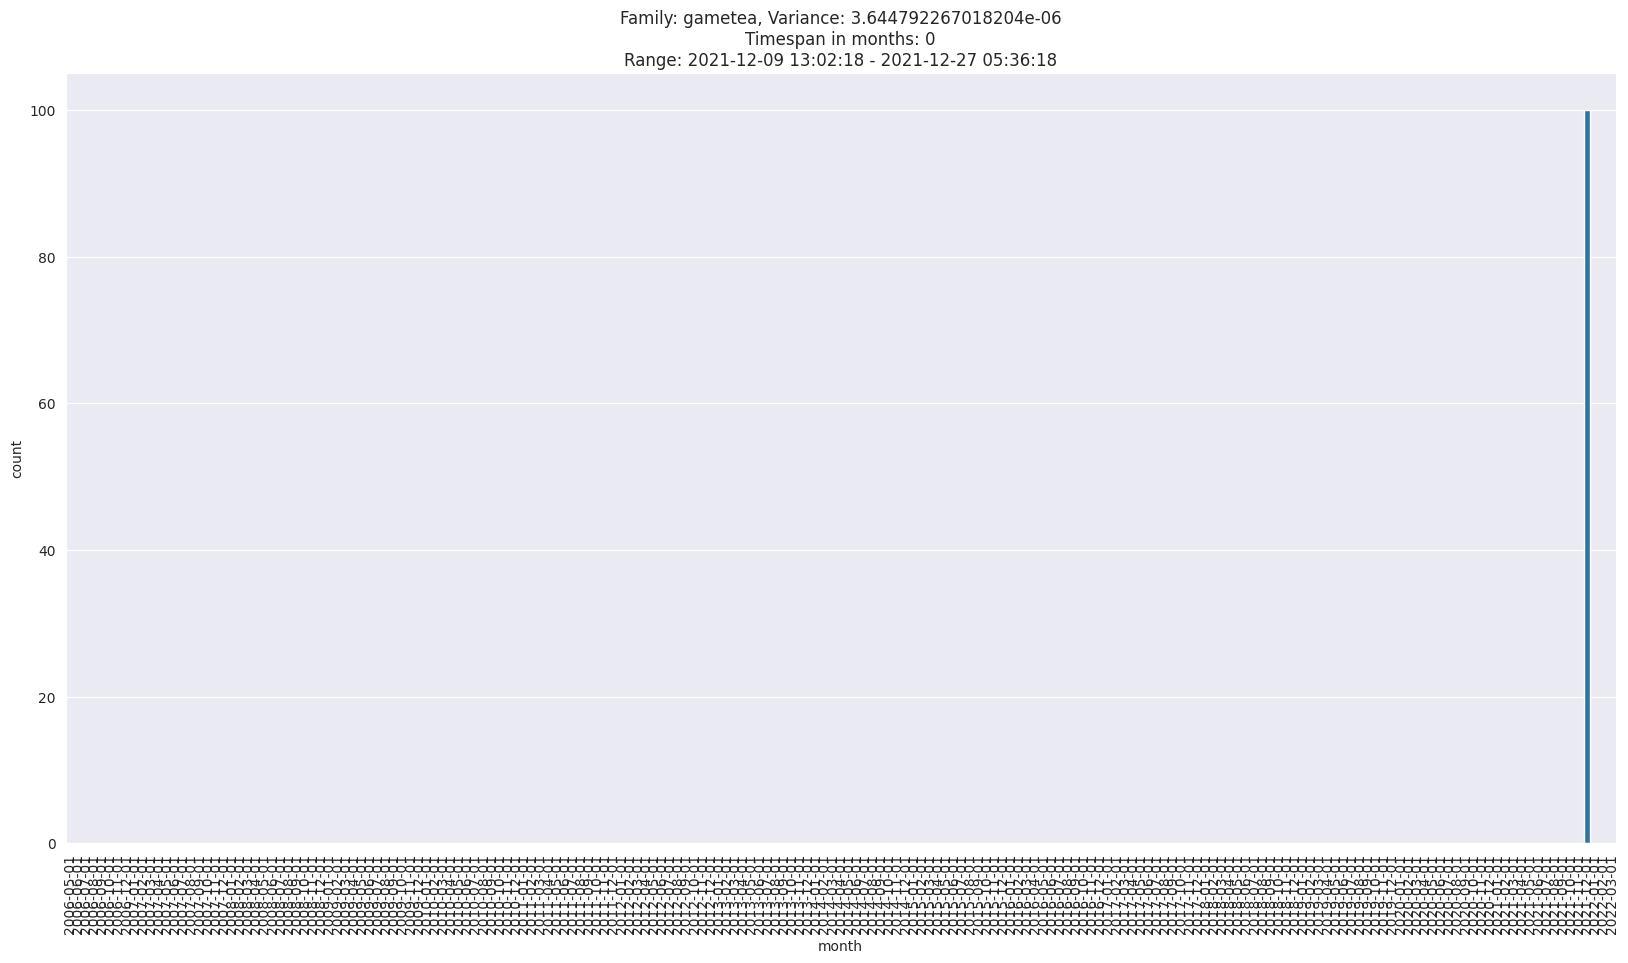

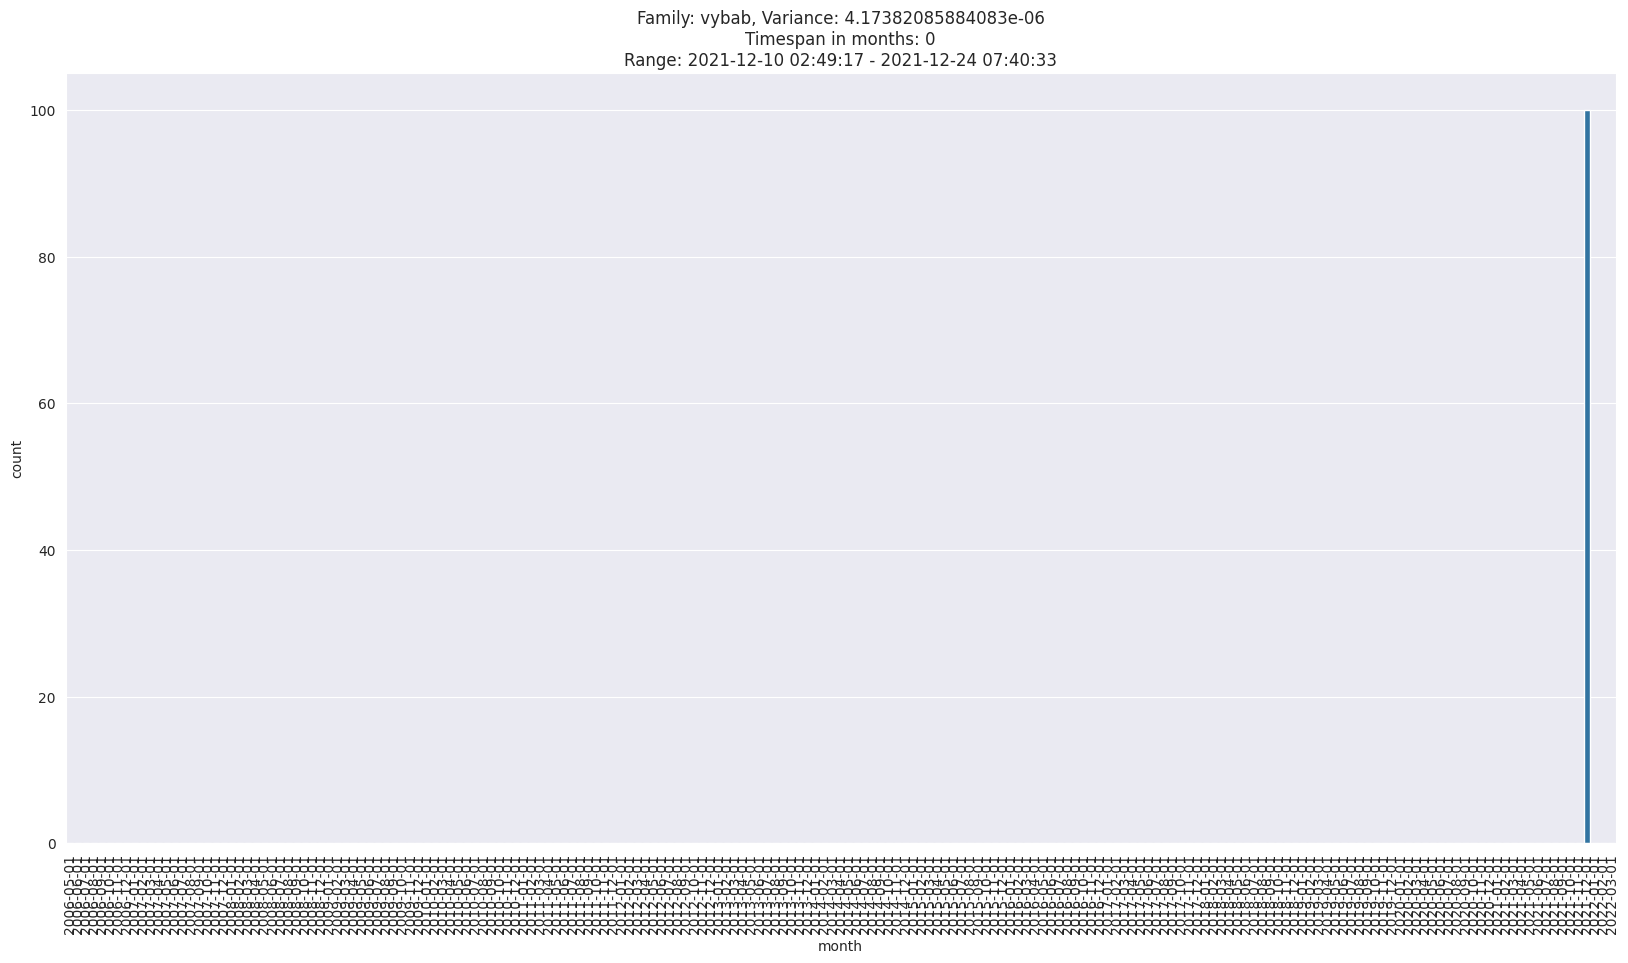

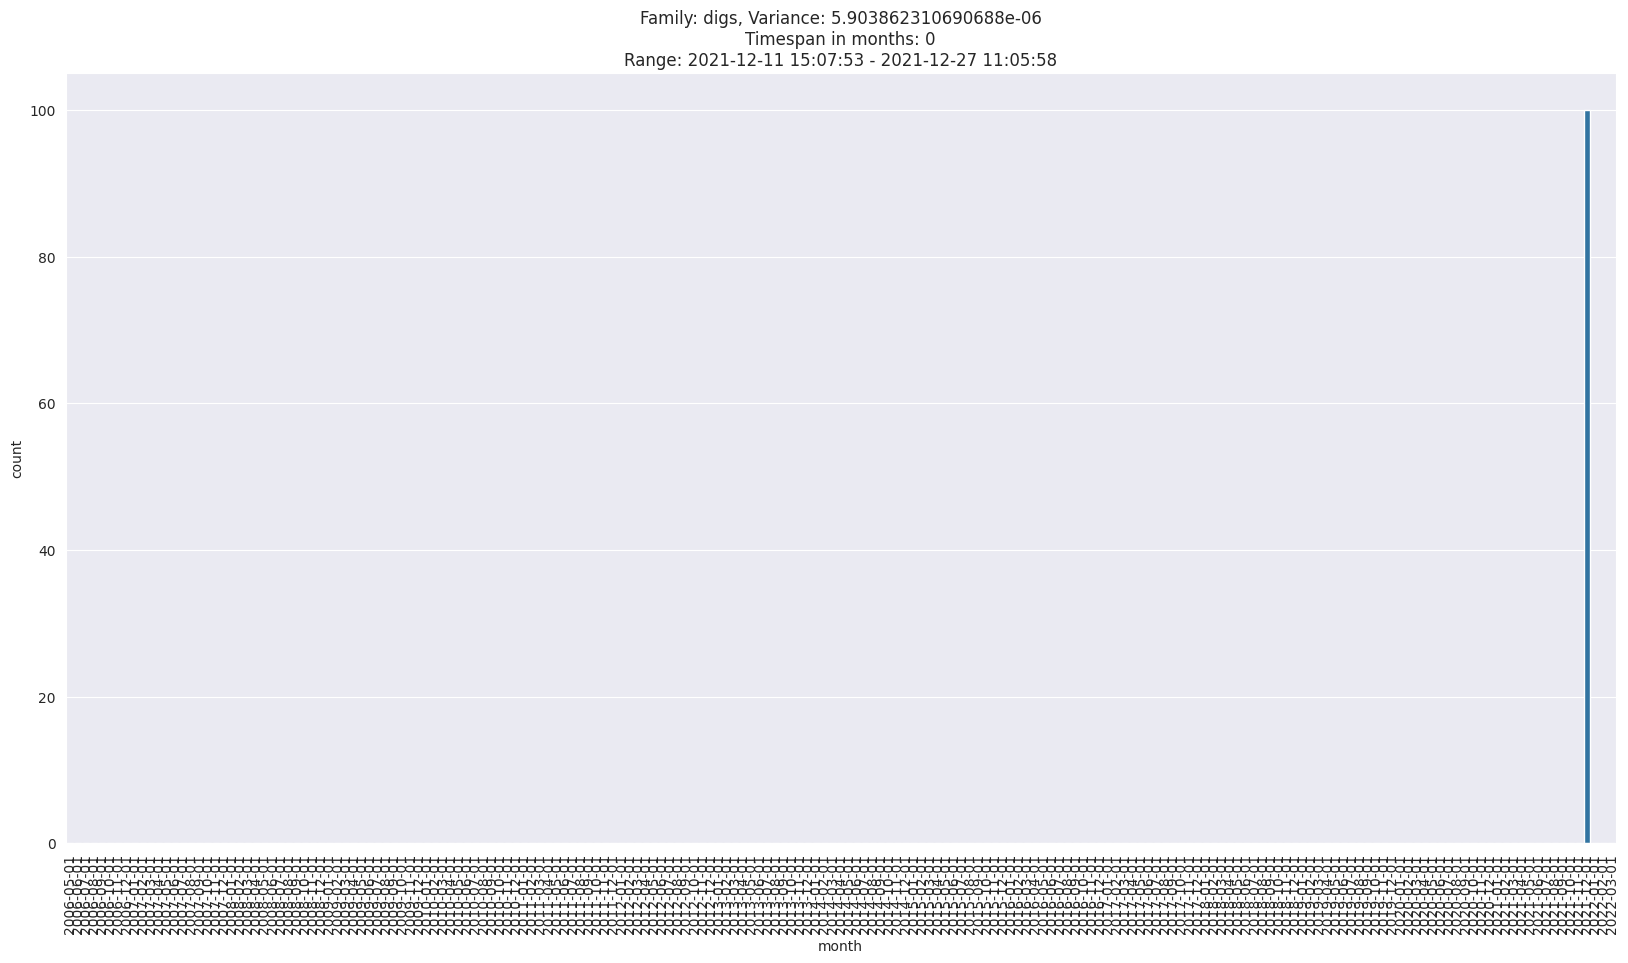

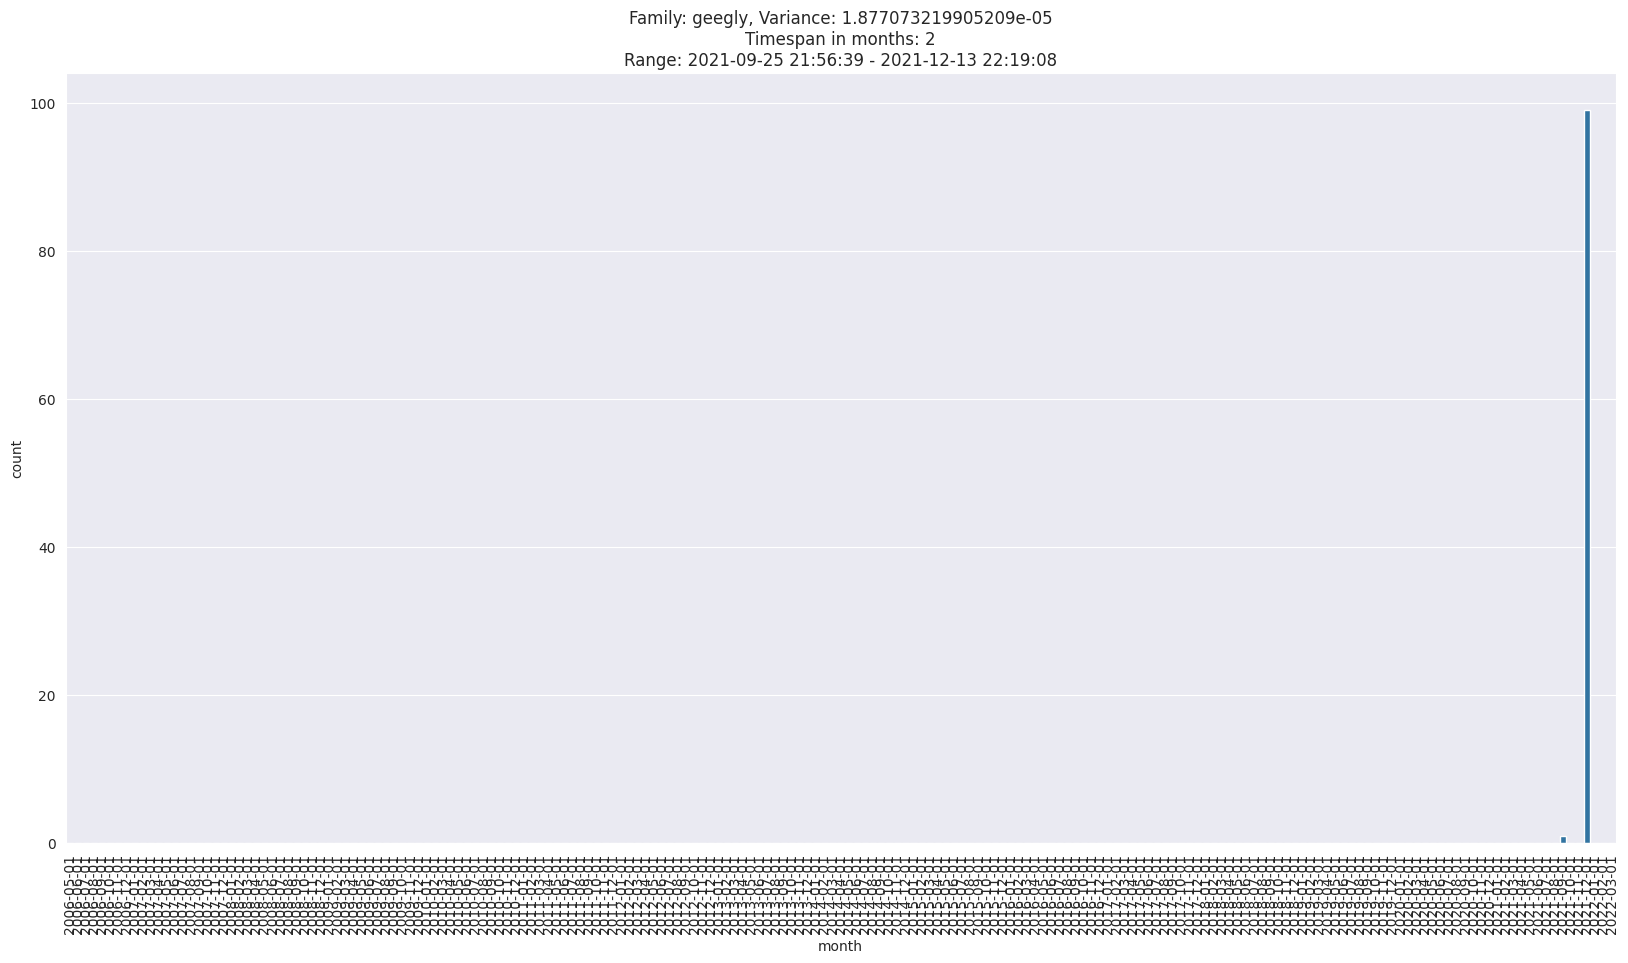

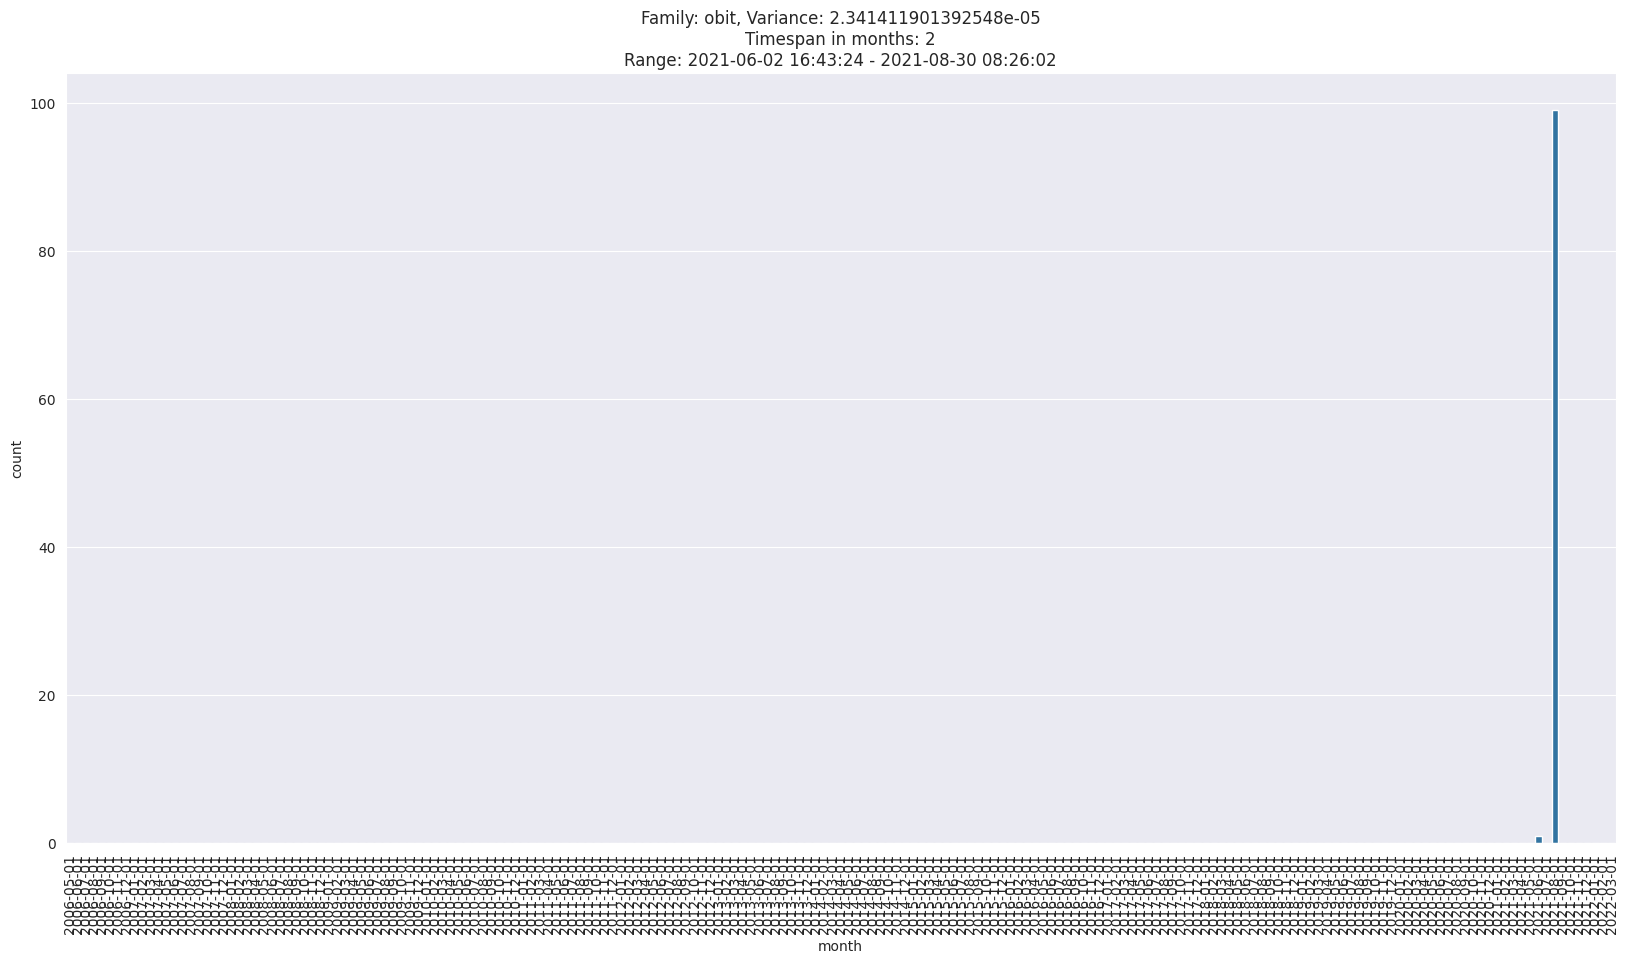

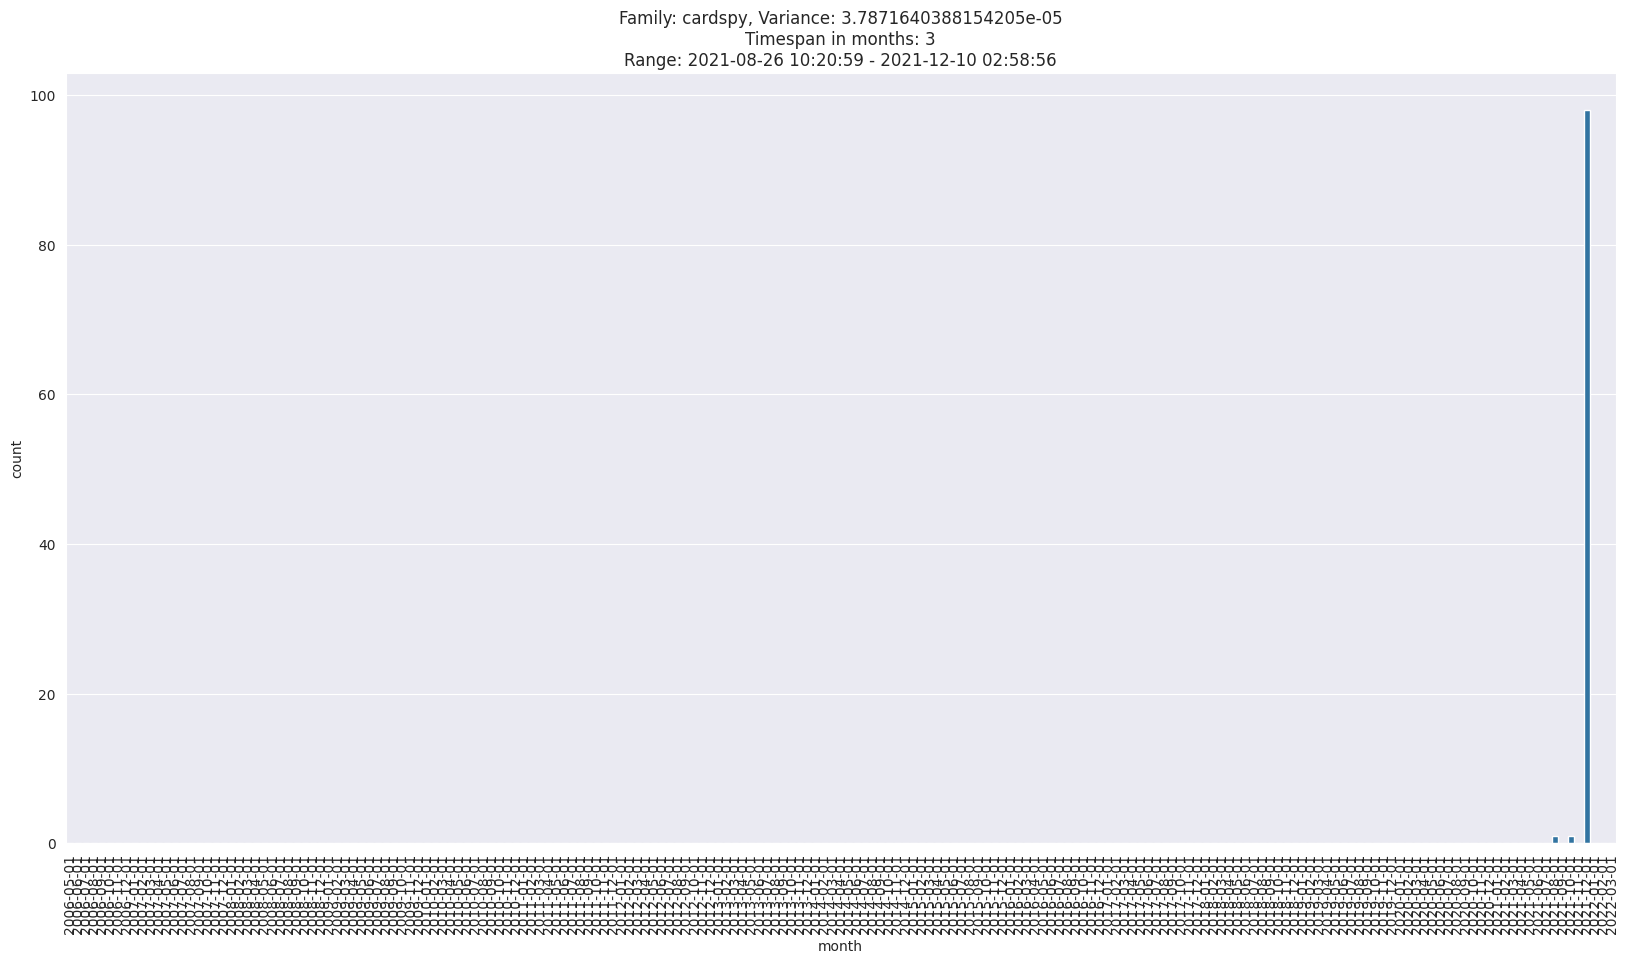

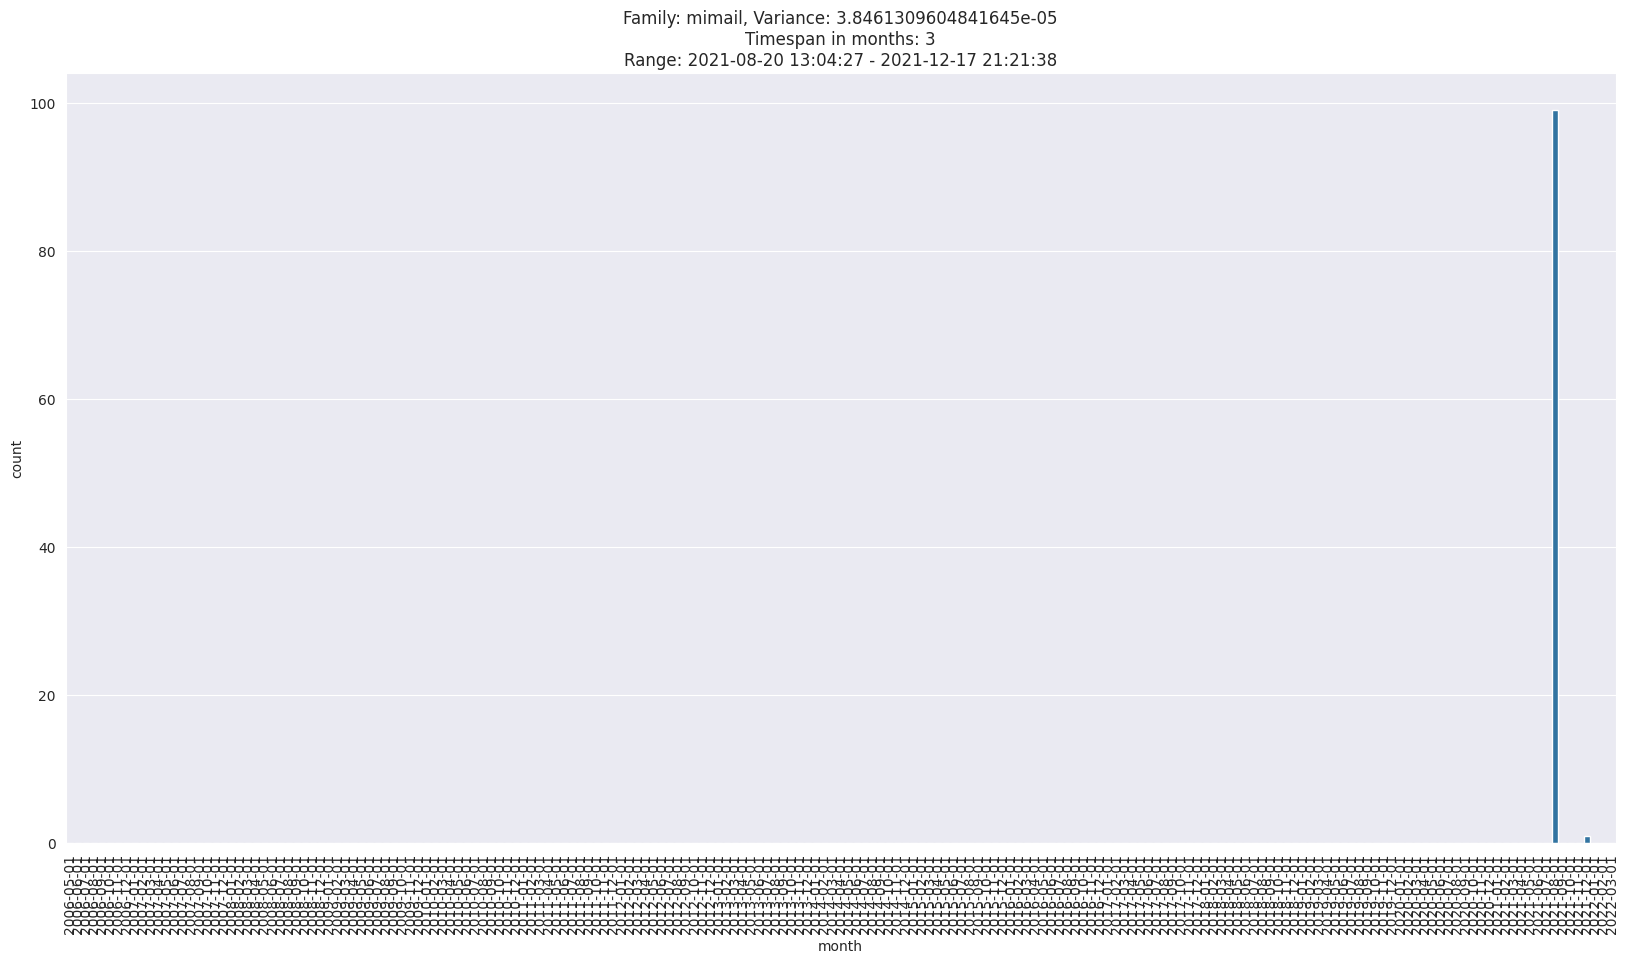

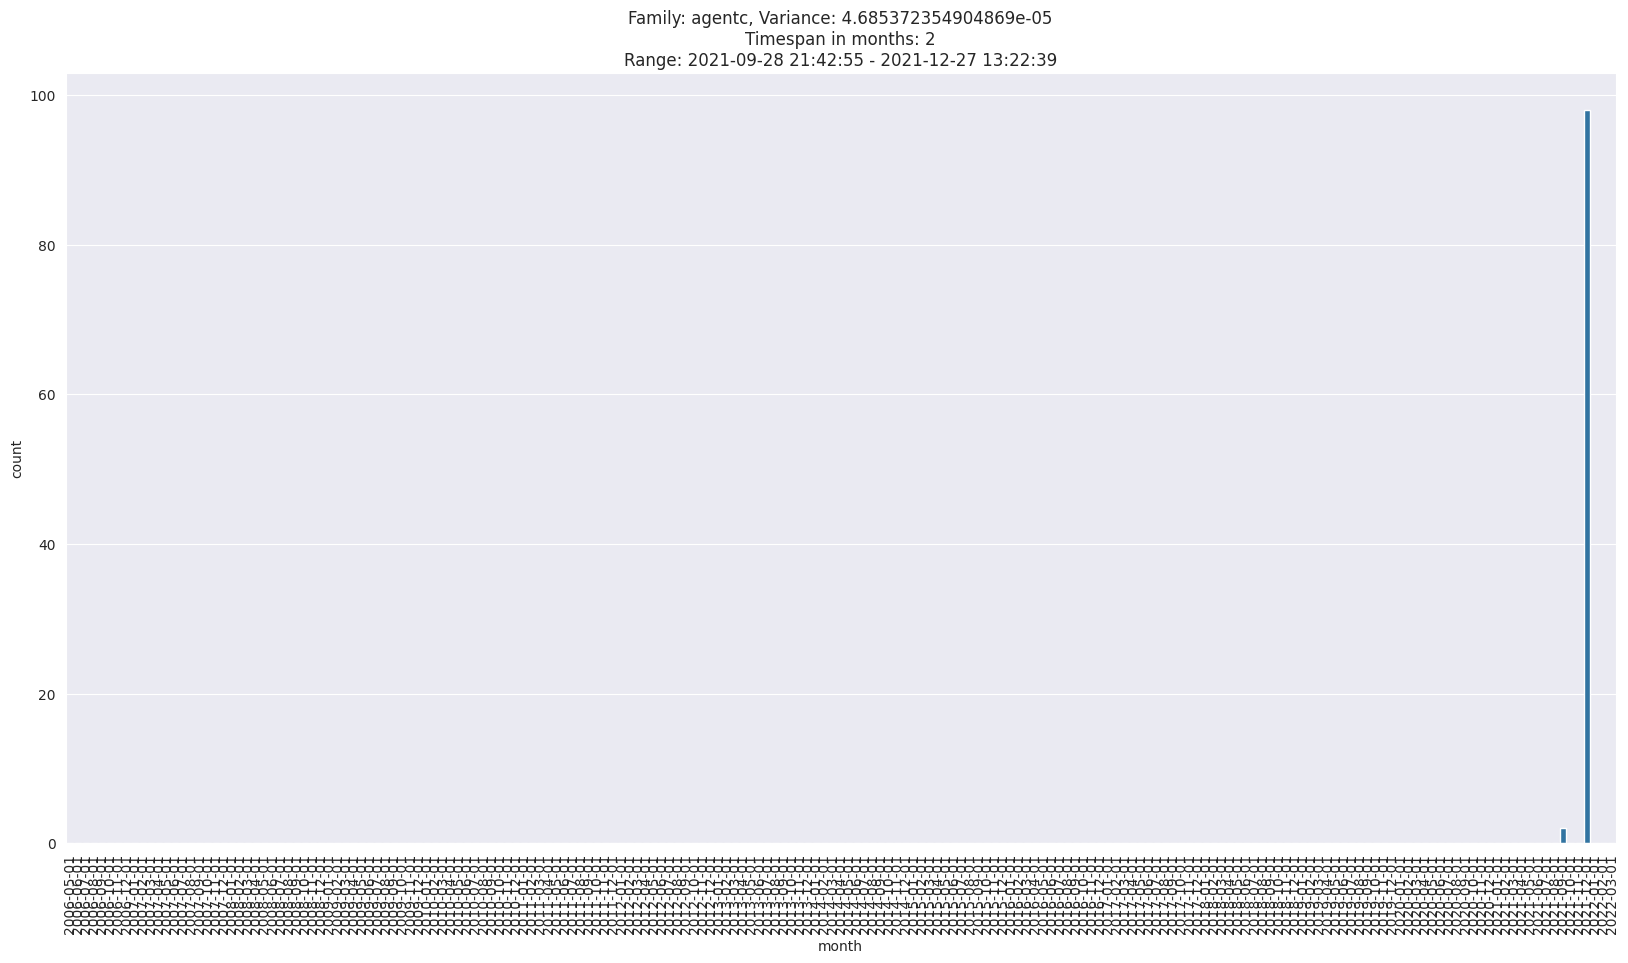

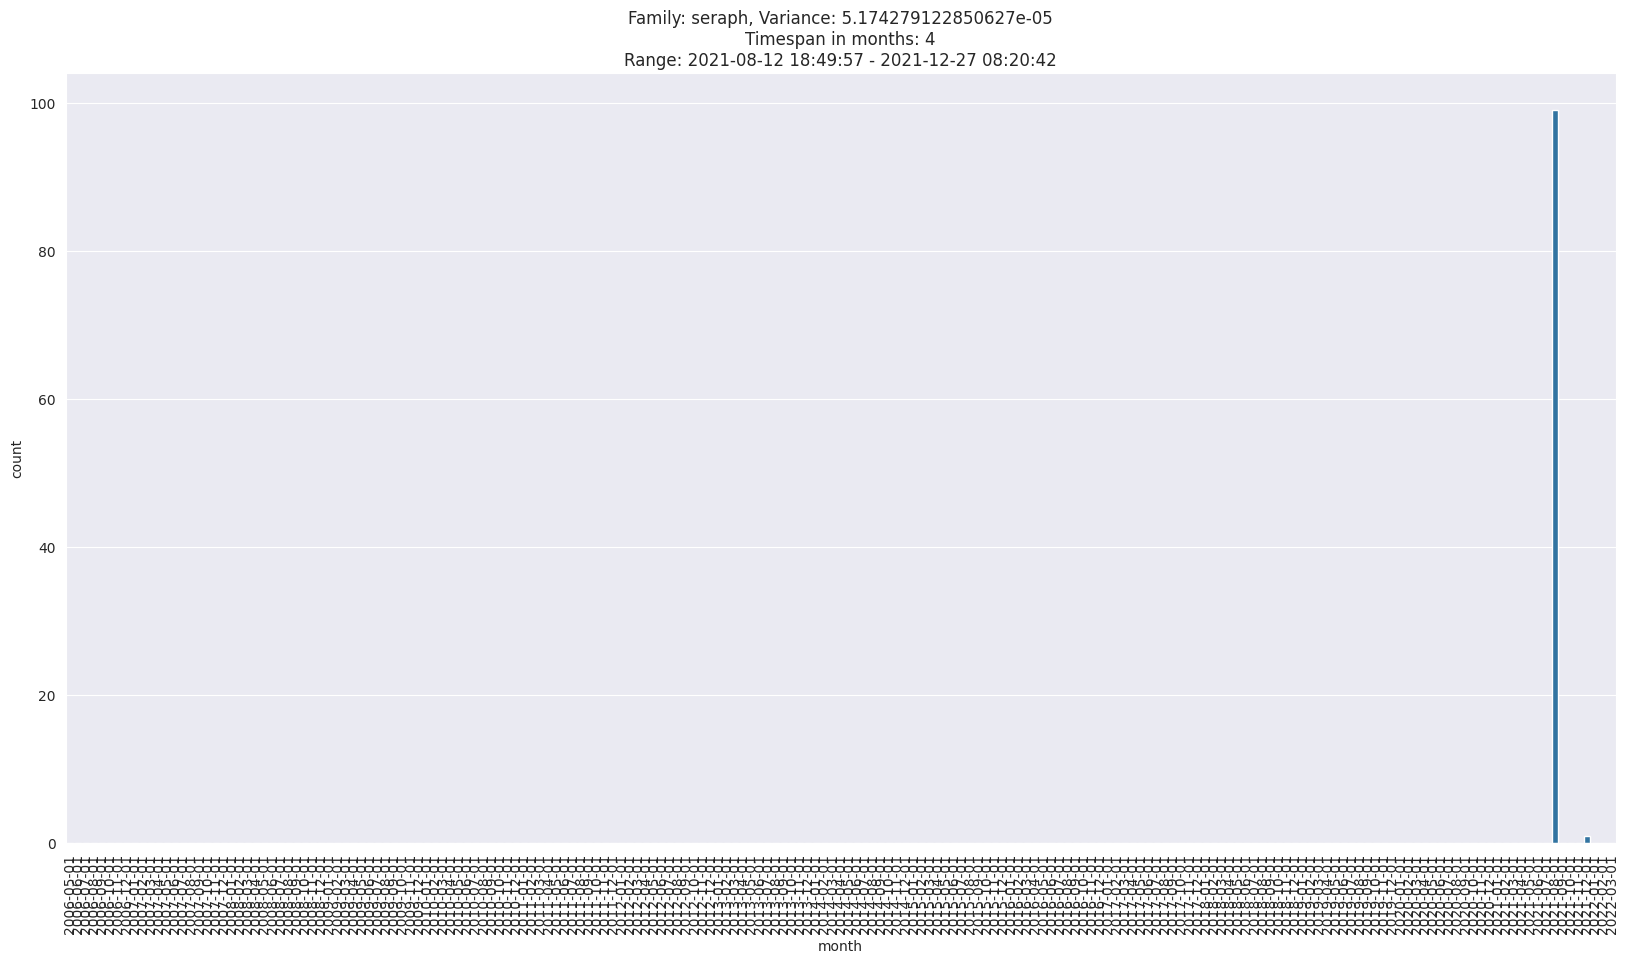

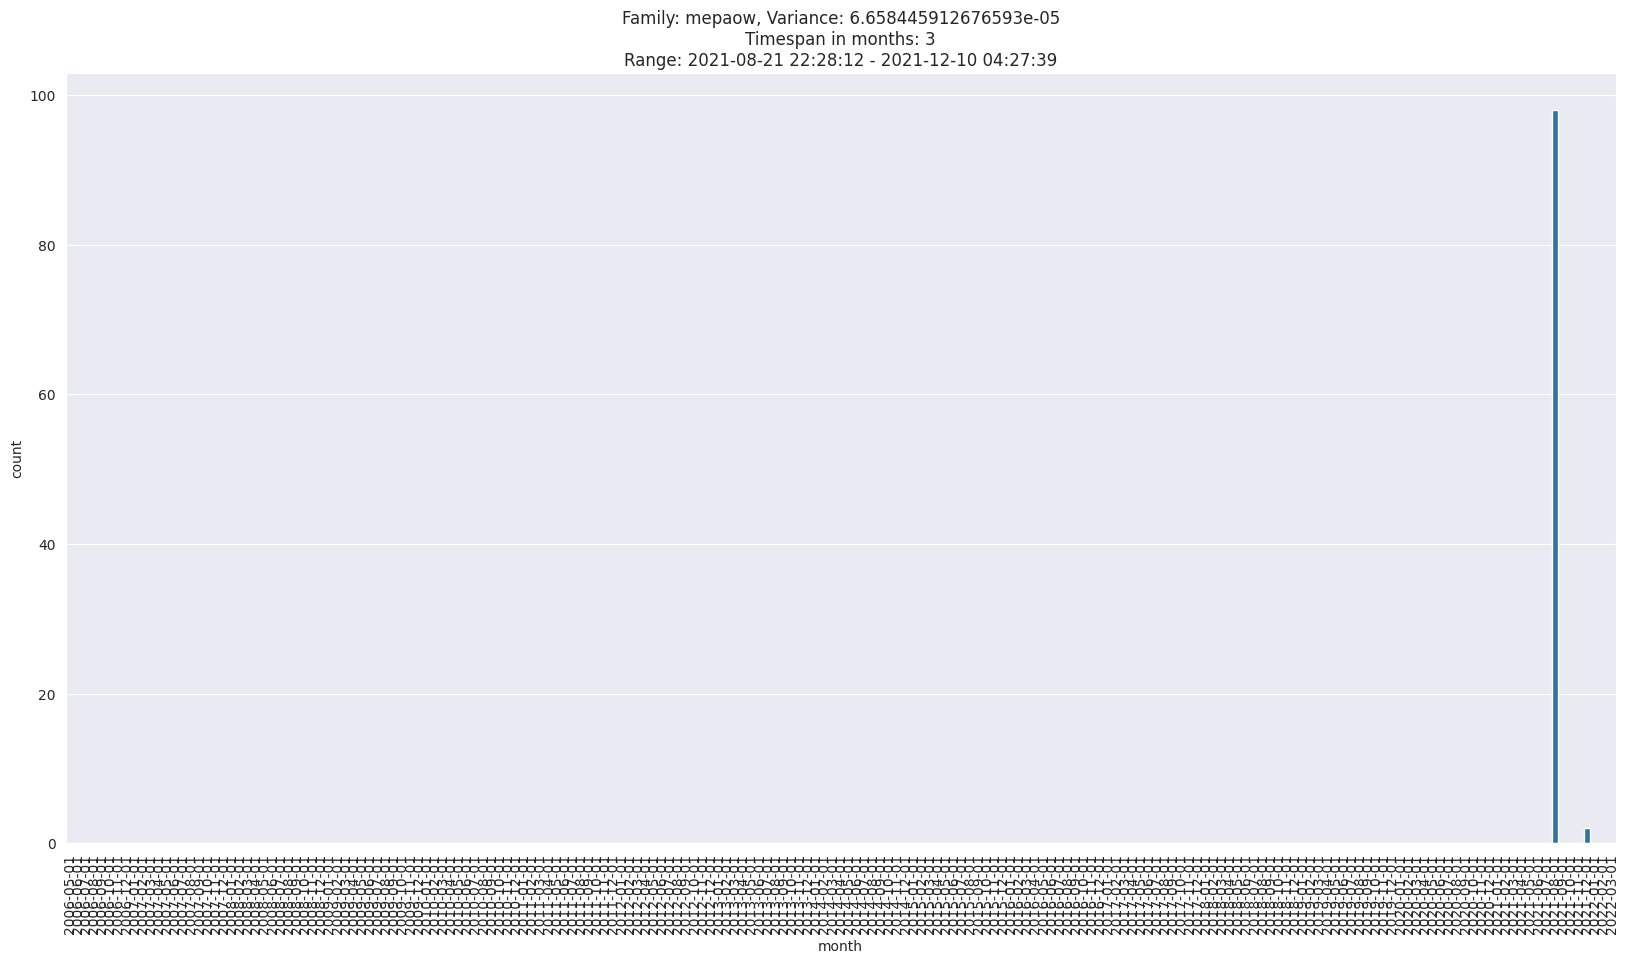

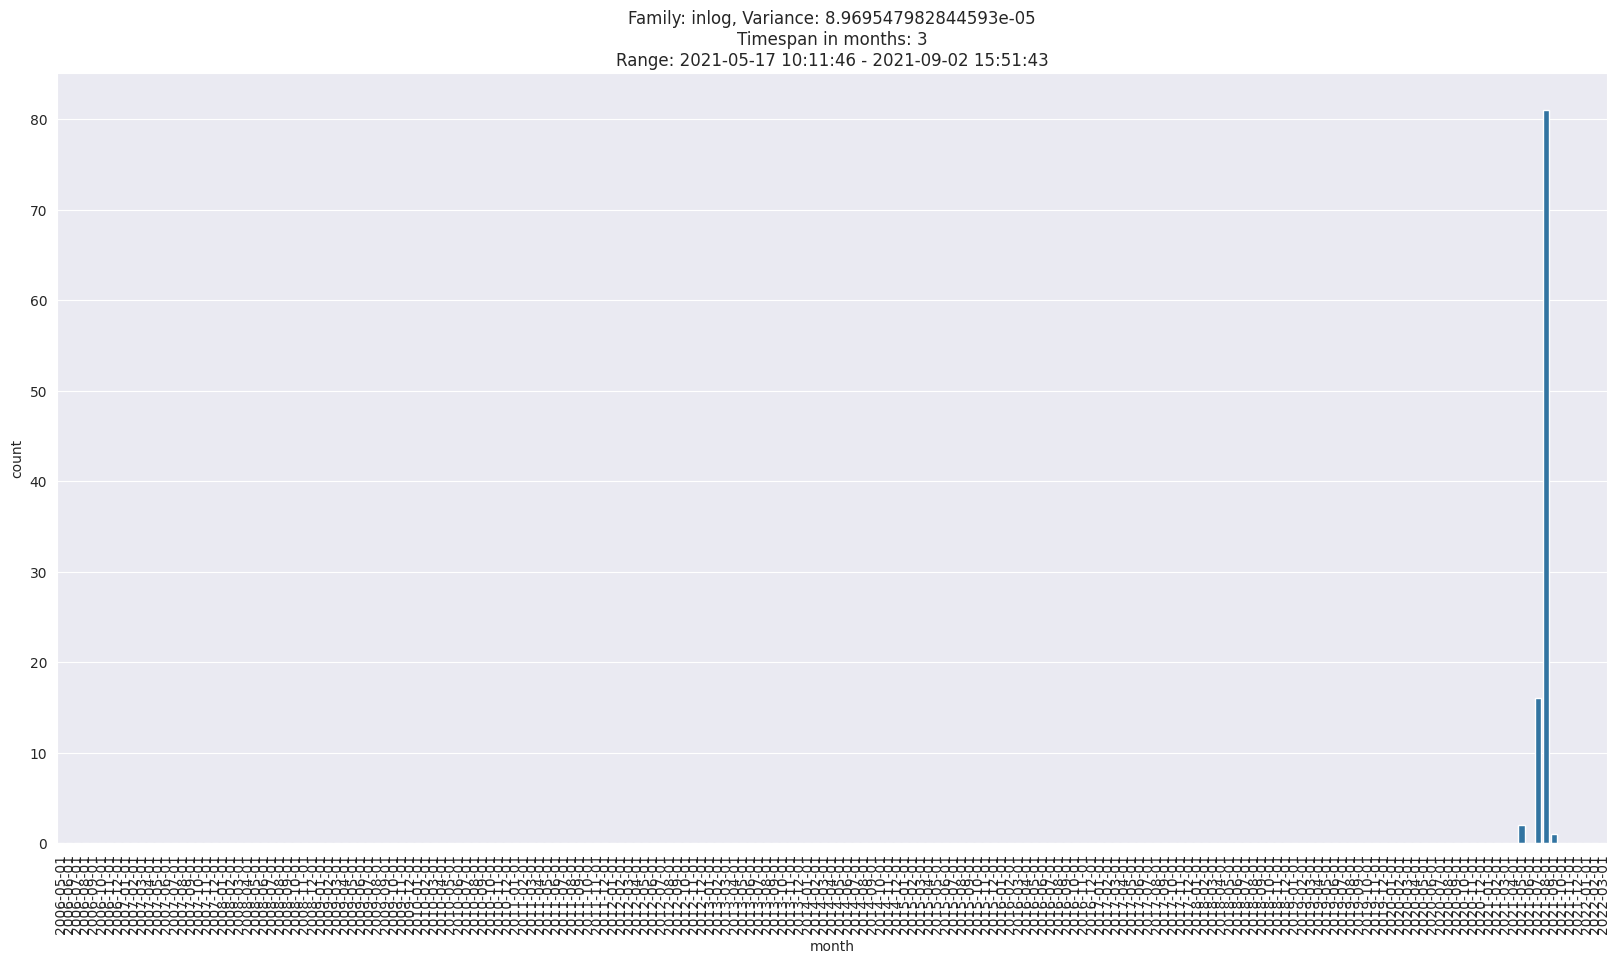

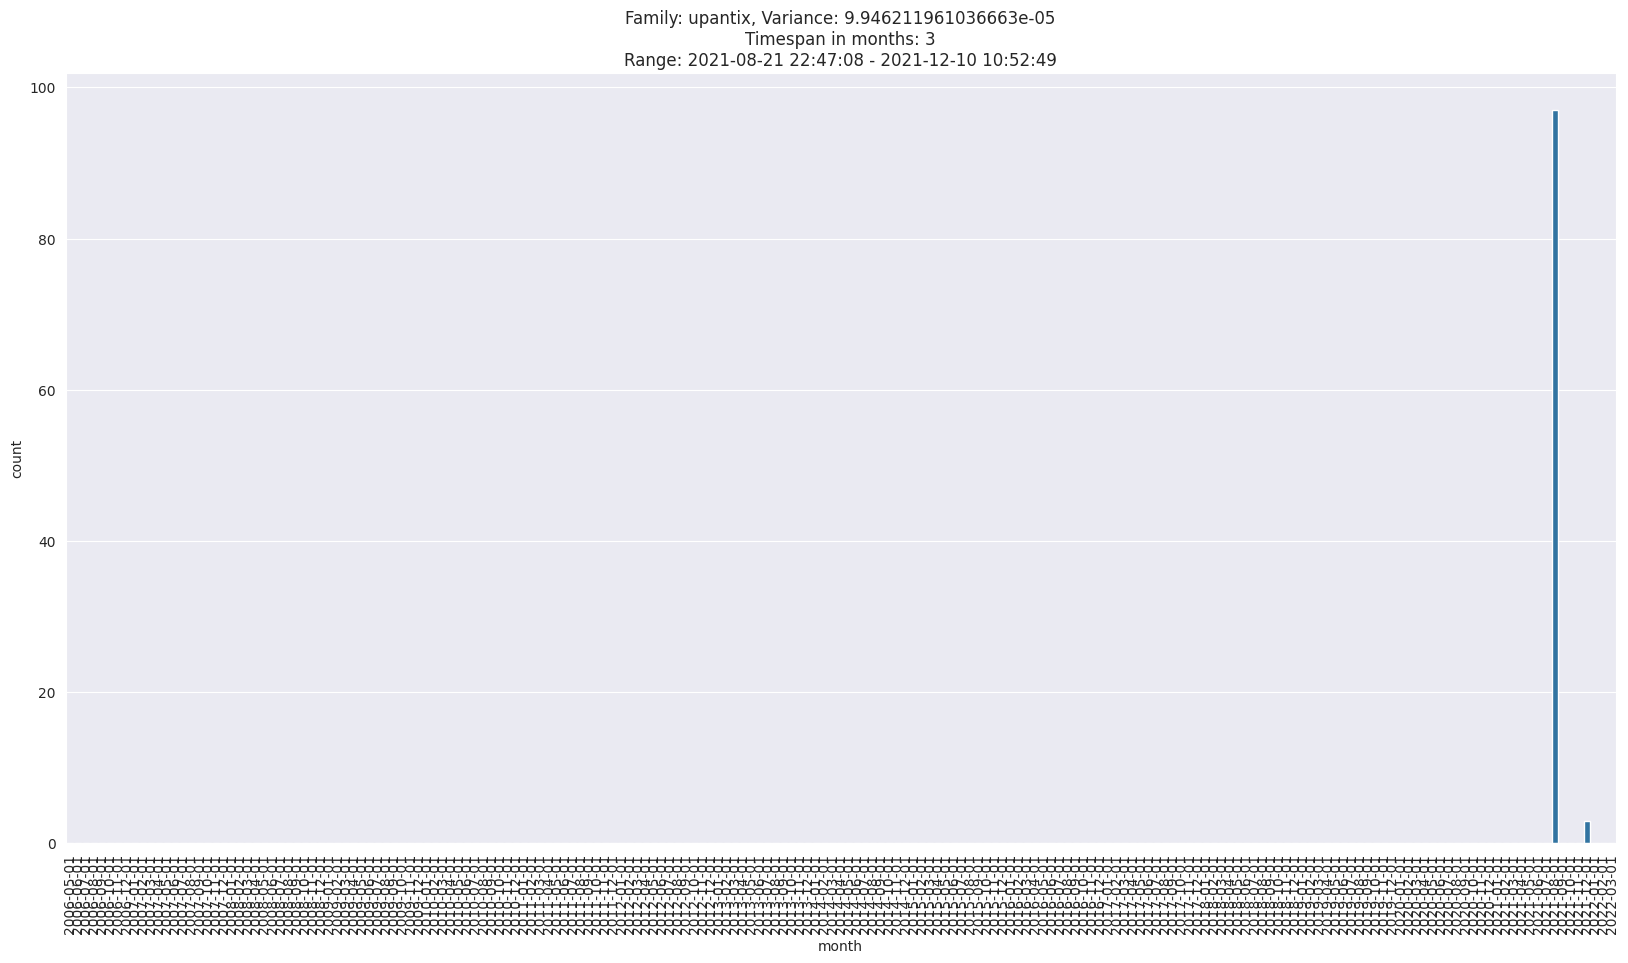

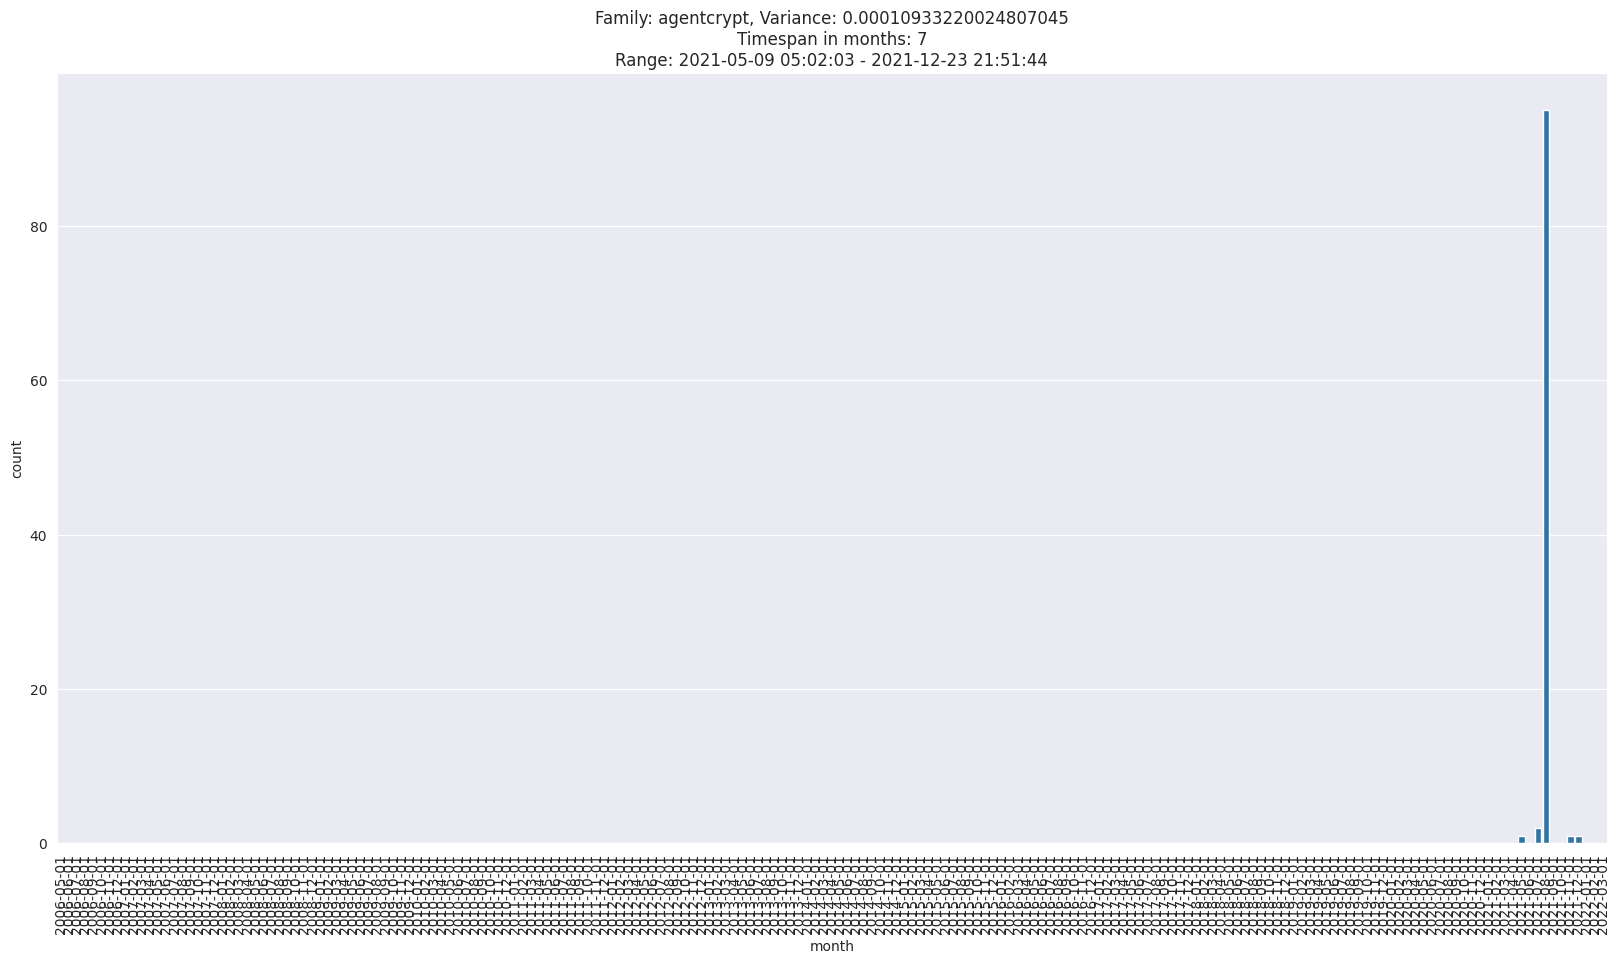

In [128]:
plot_family_distribution(df_variances.head(20))

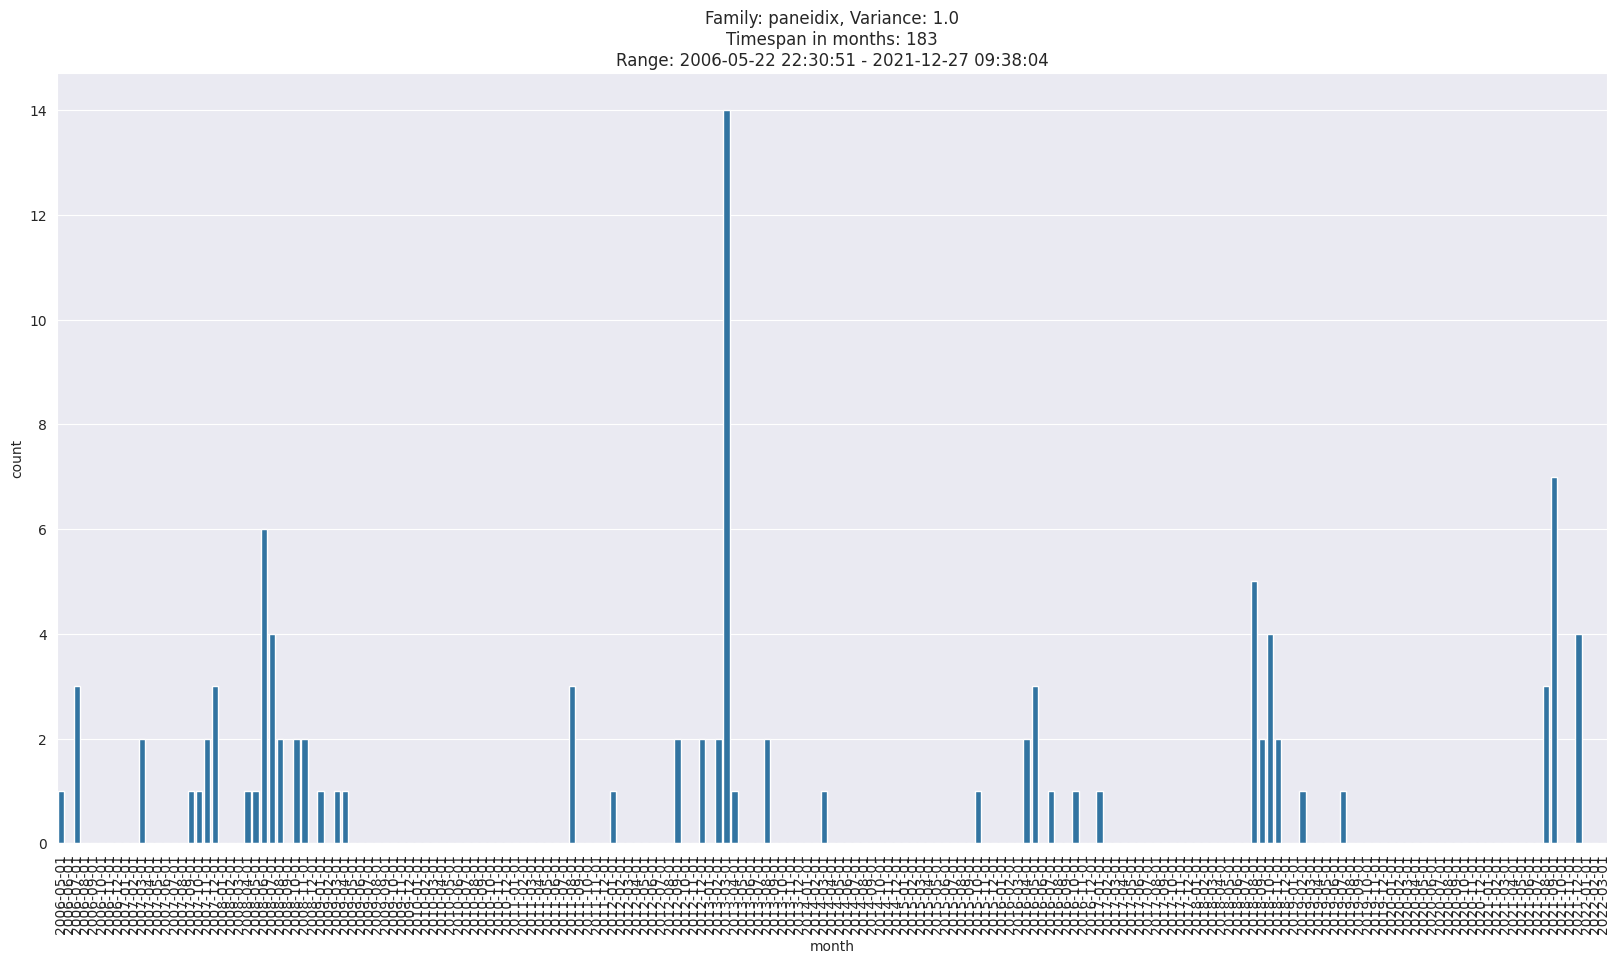

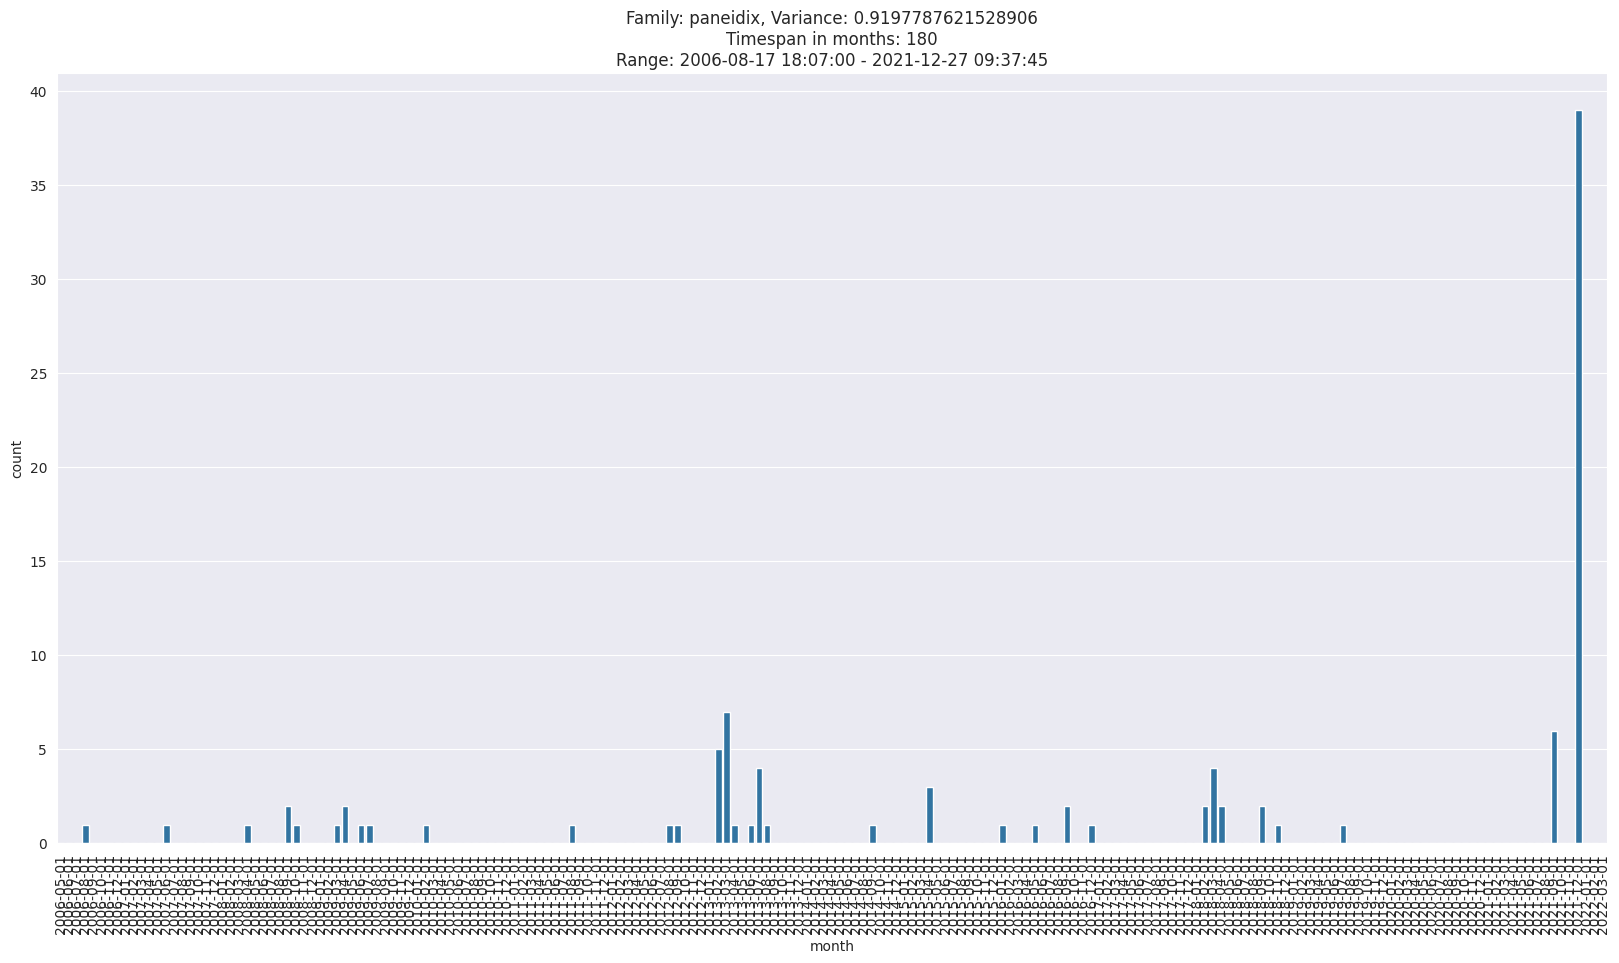

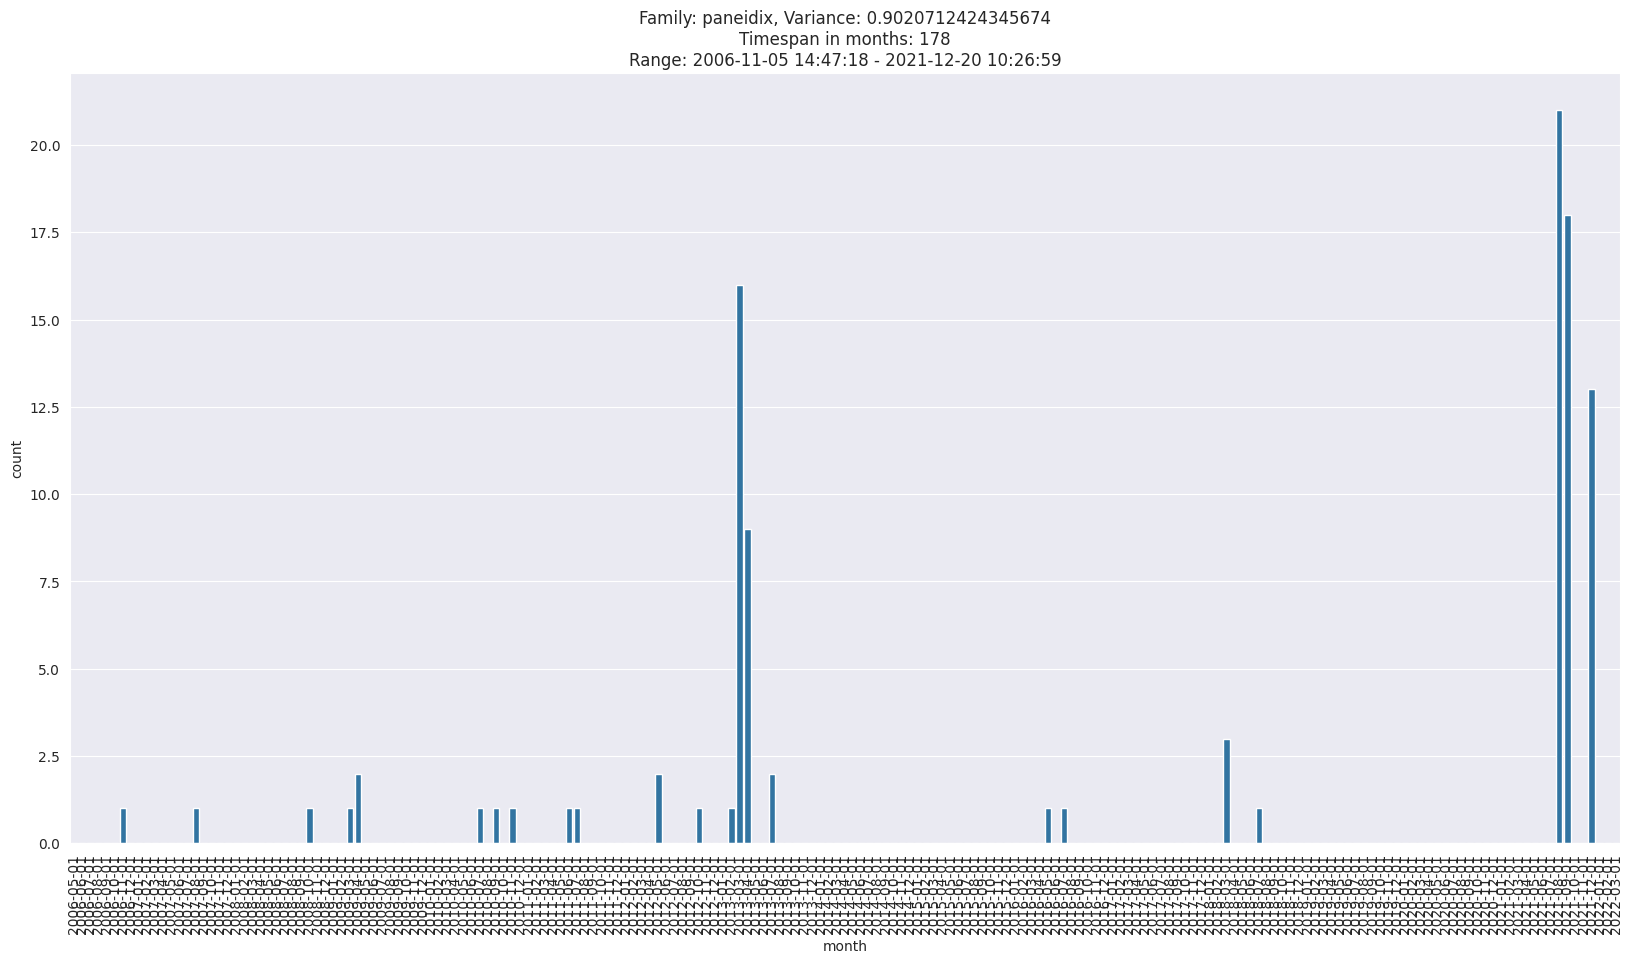

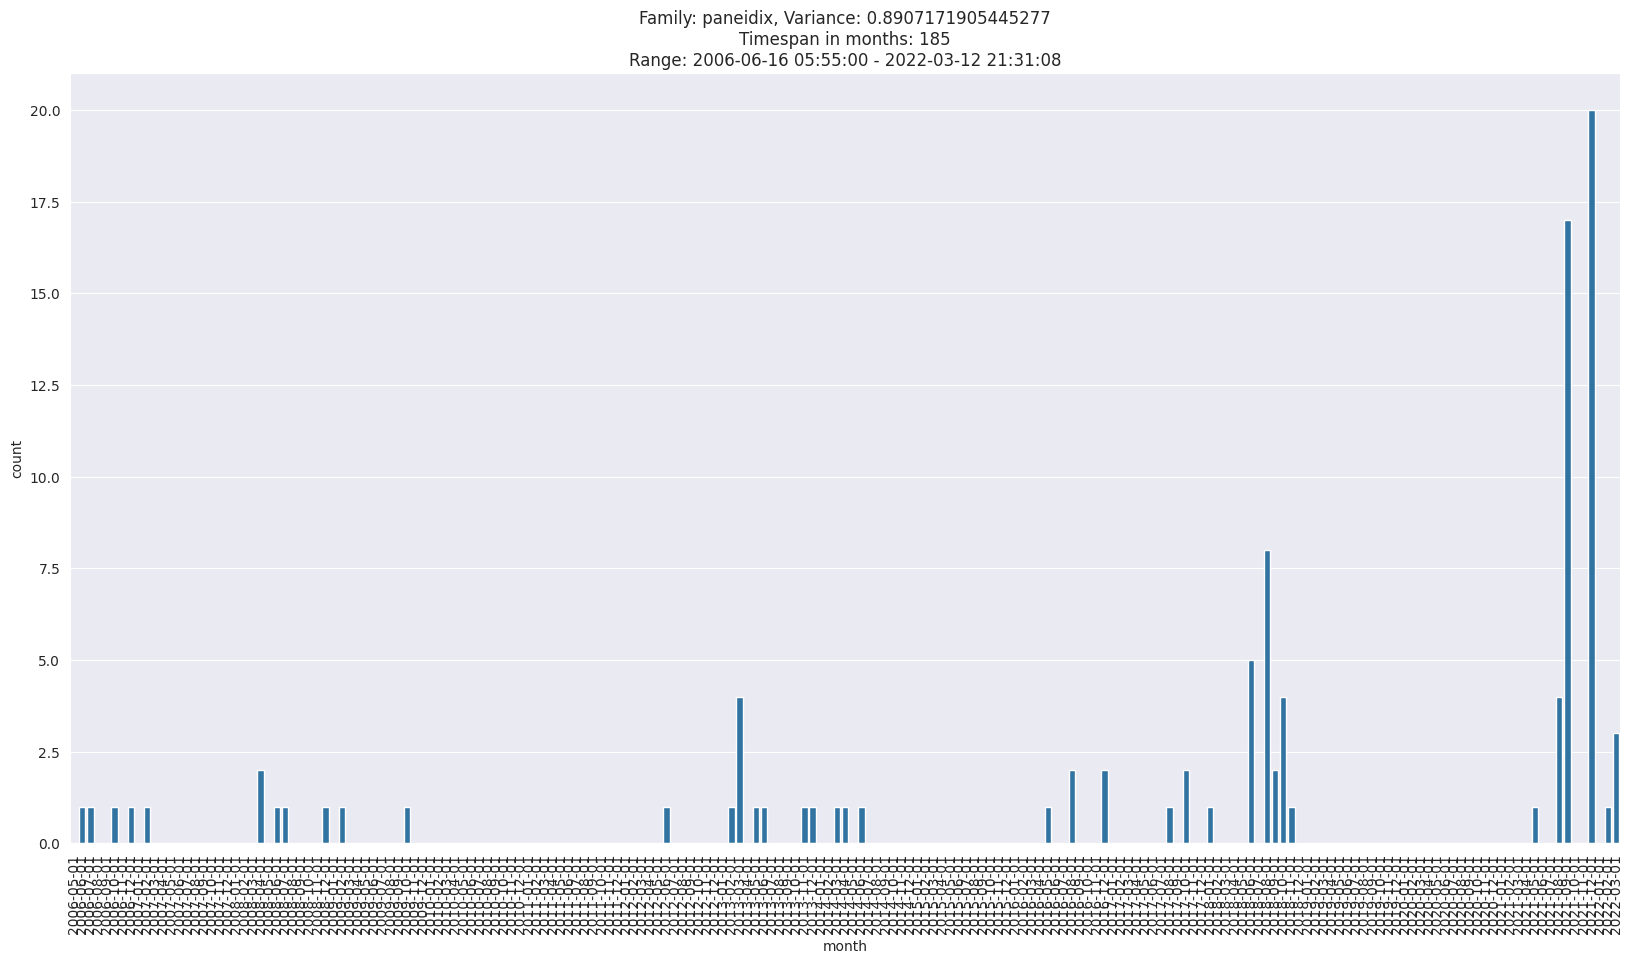

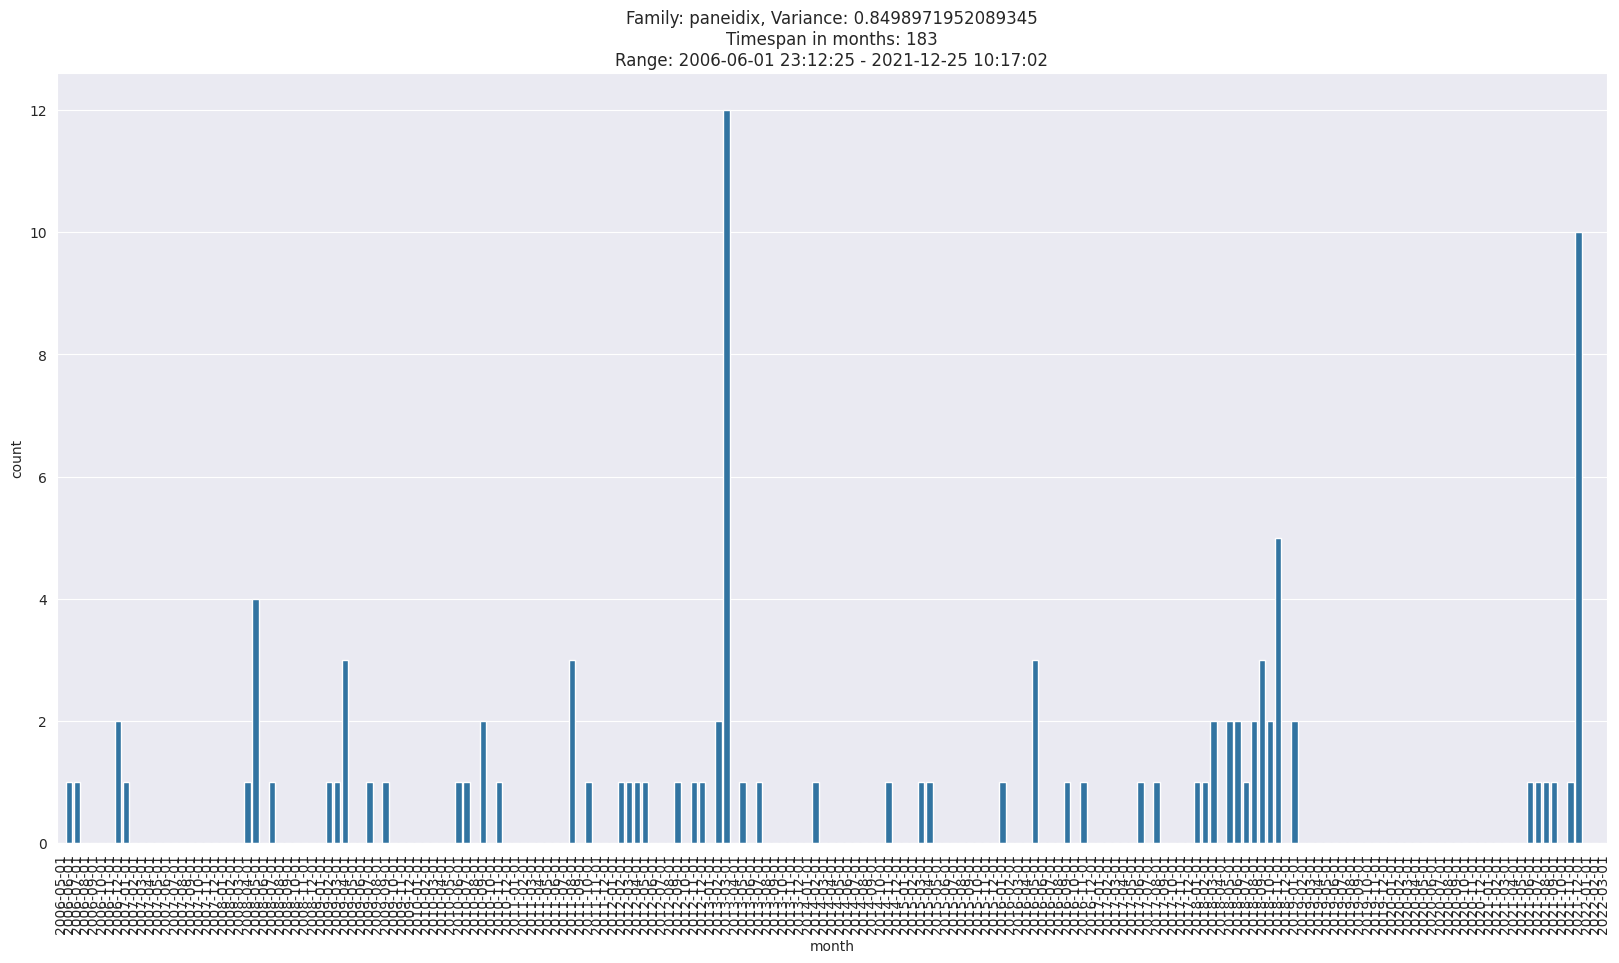

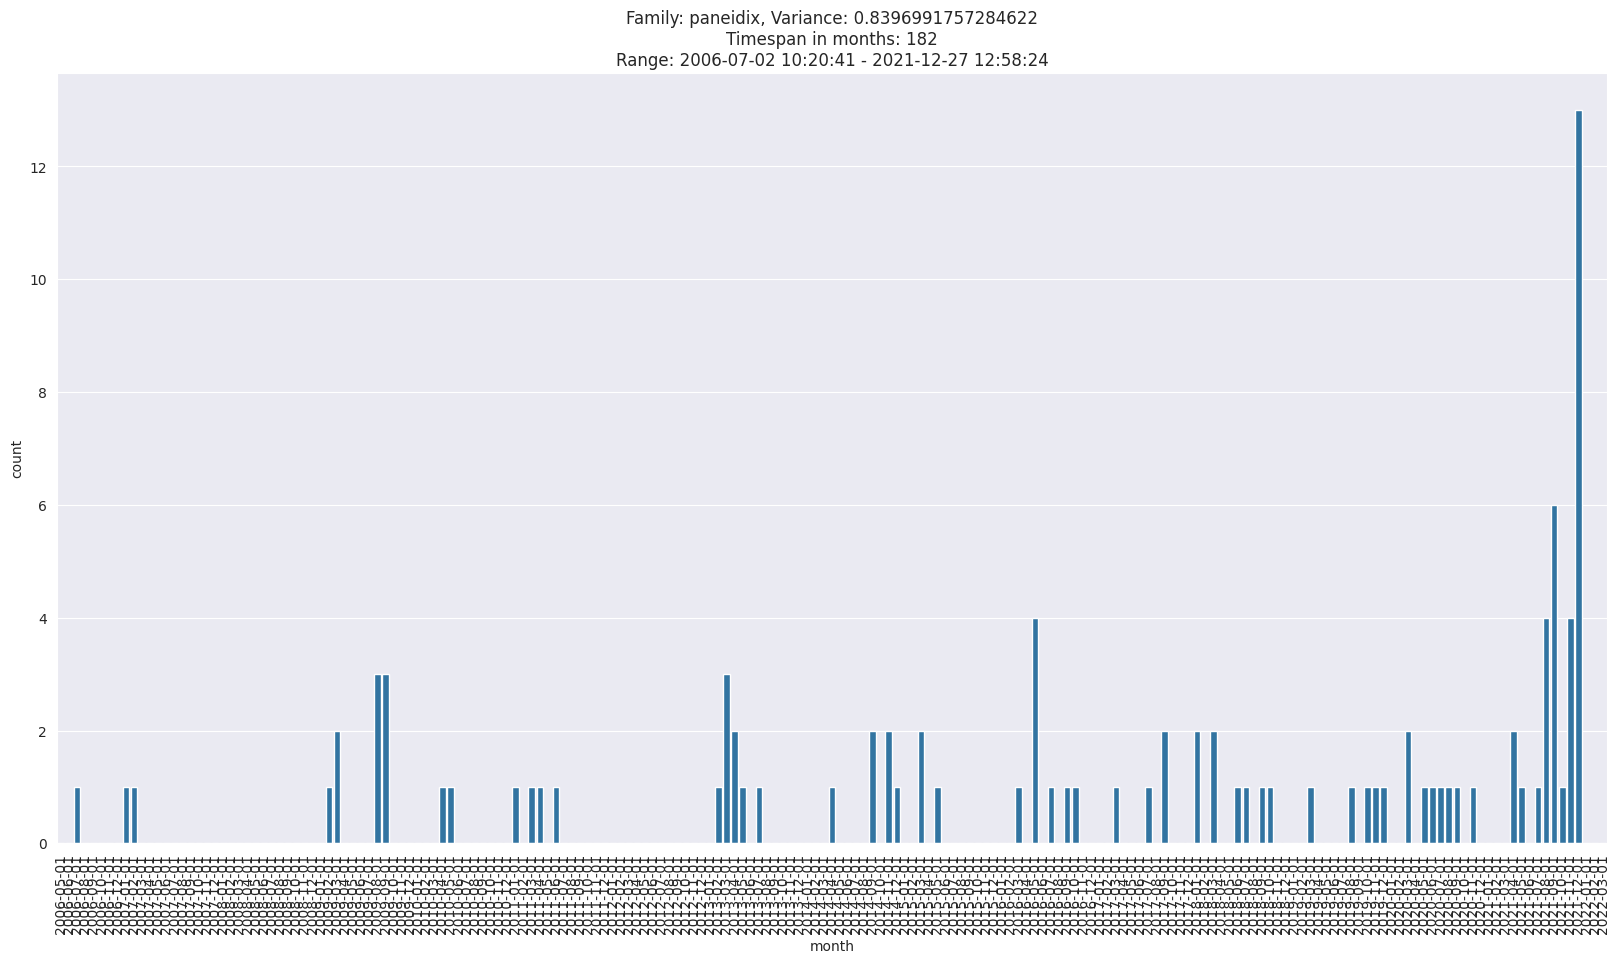

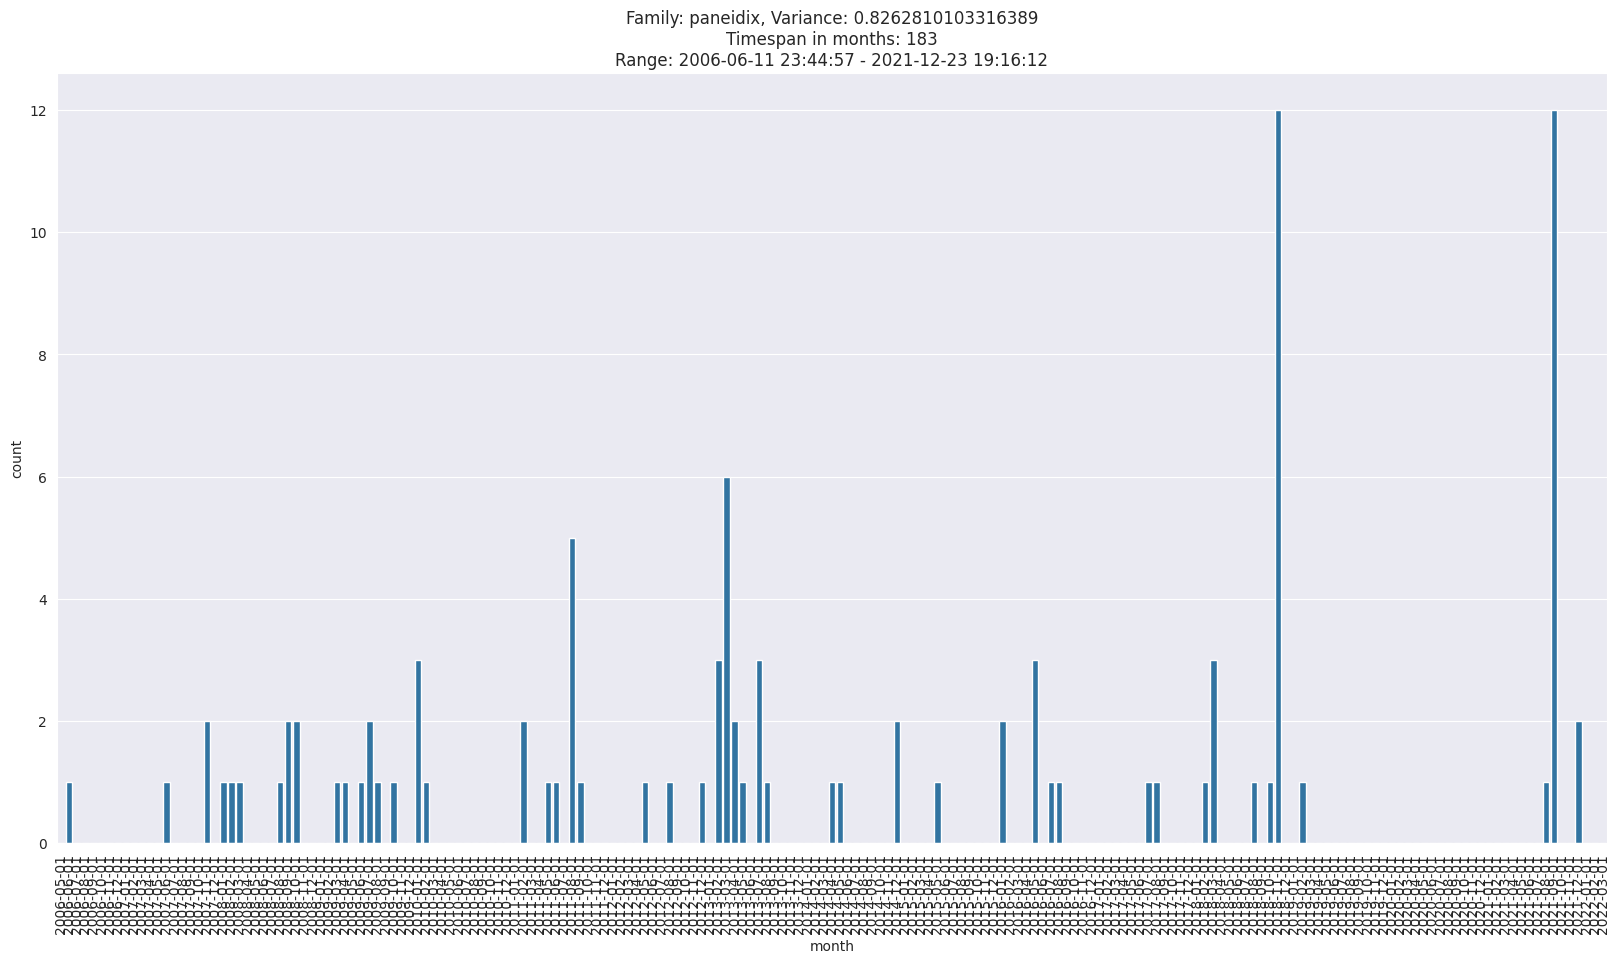

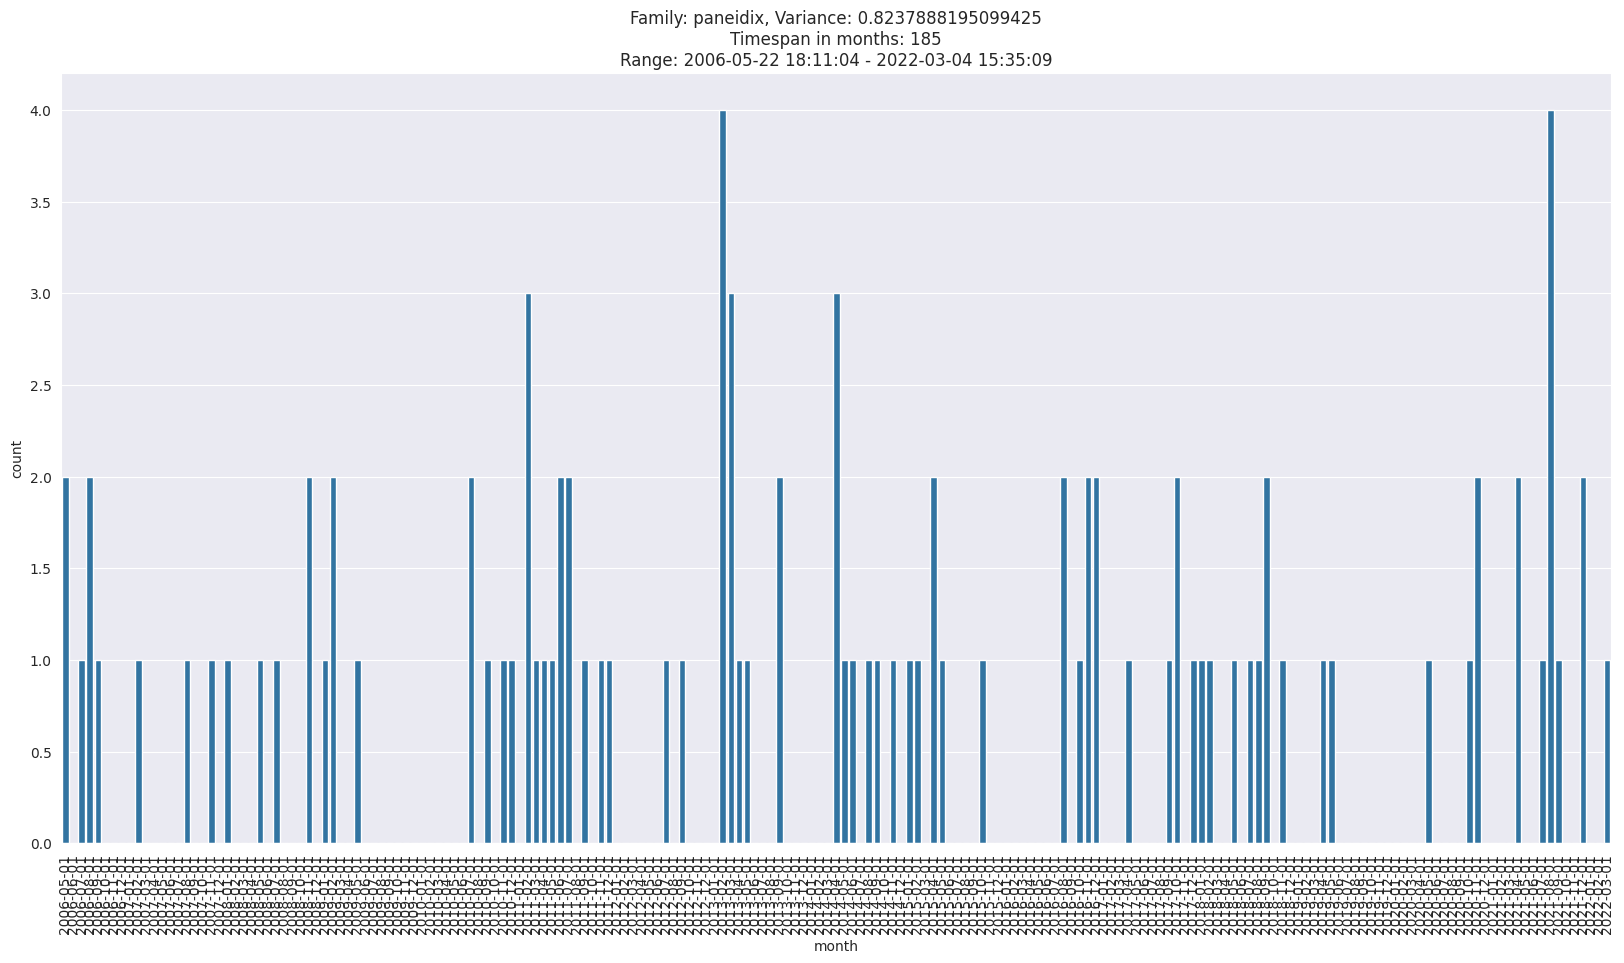

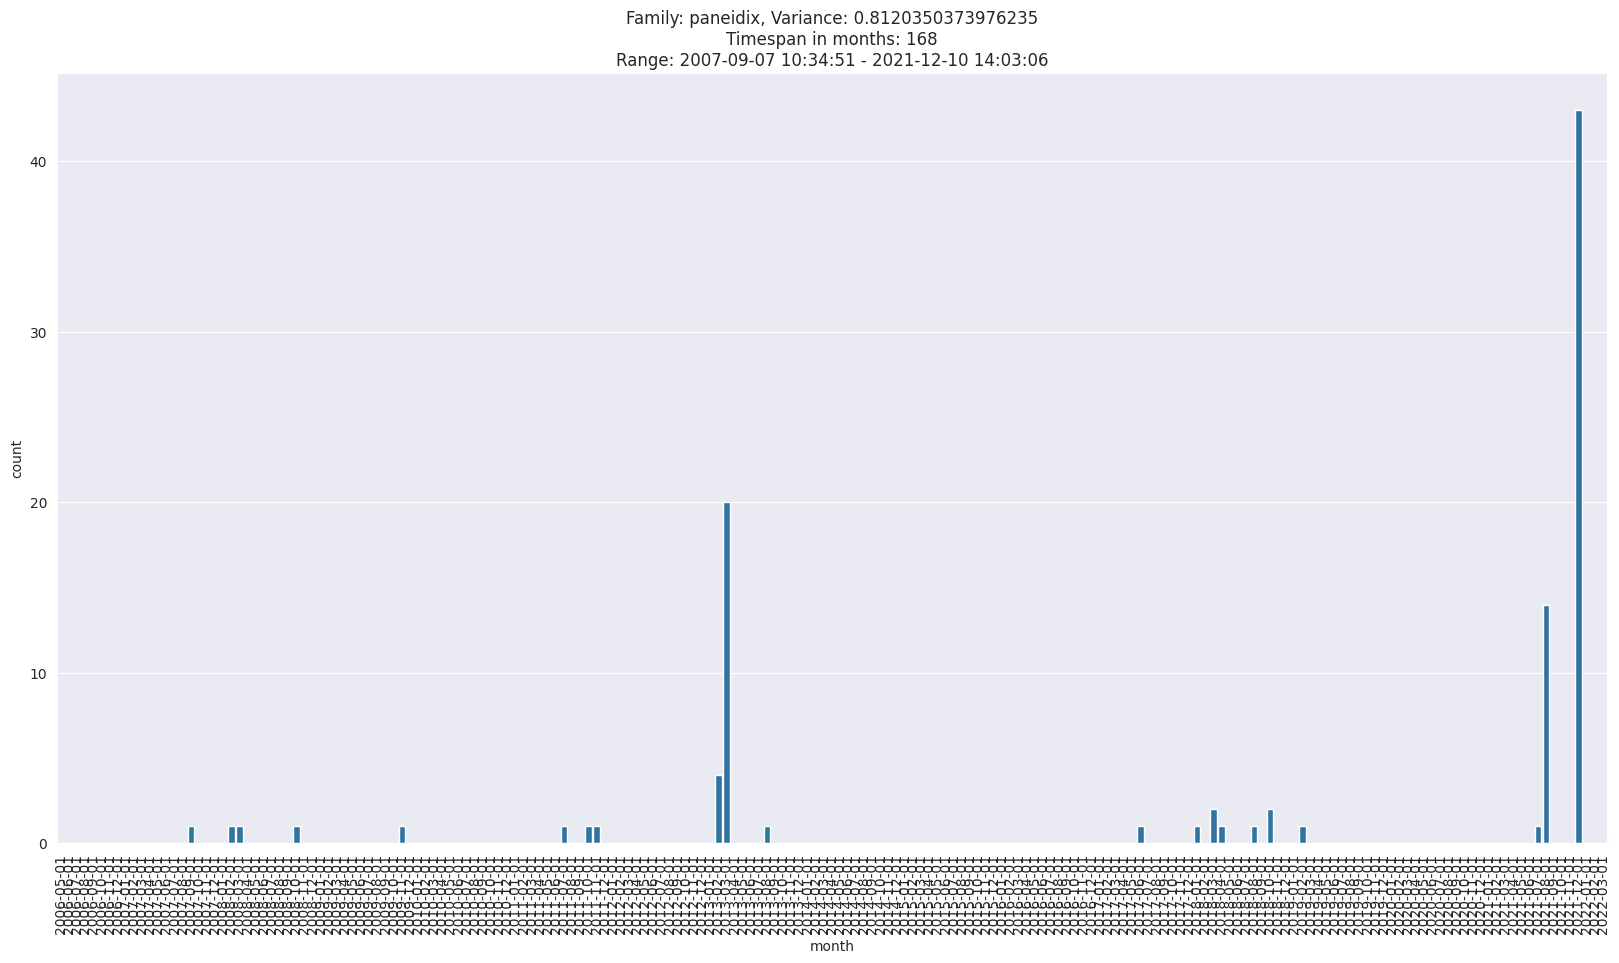

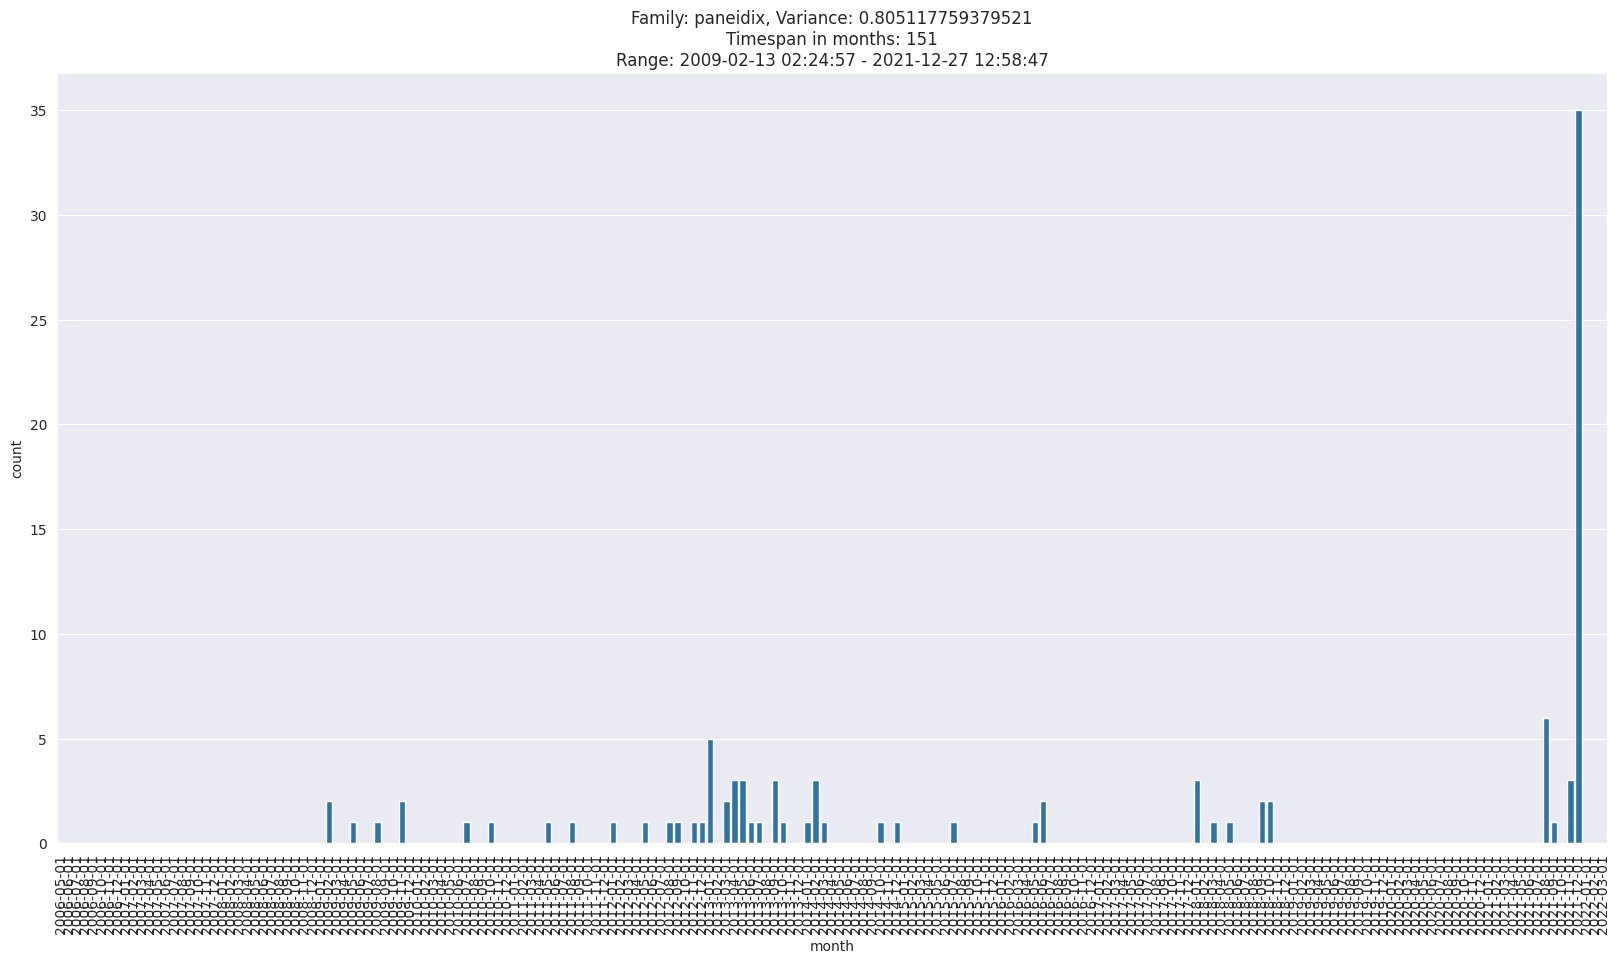

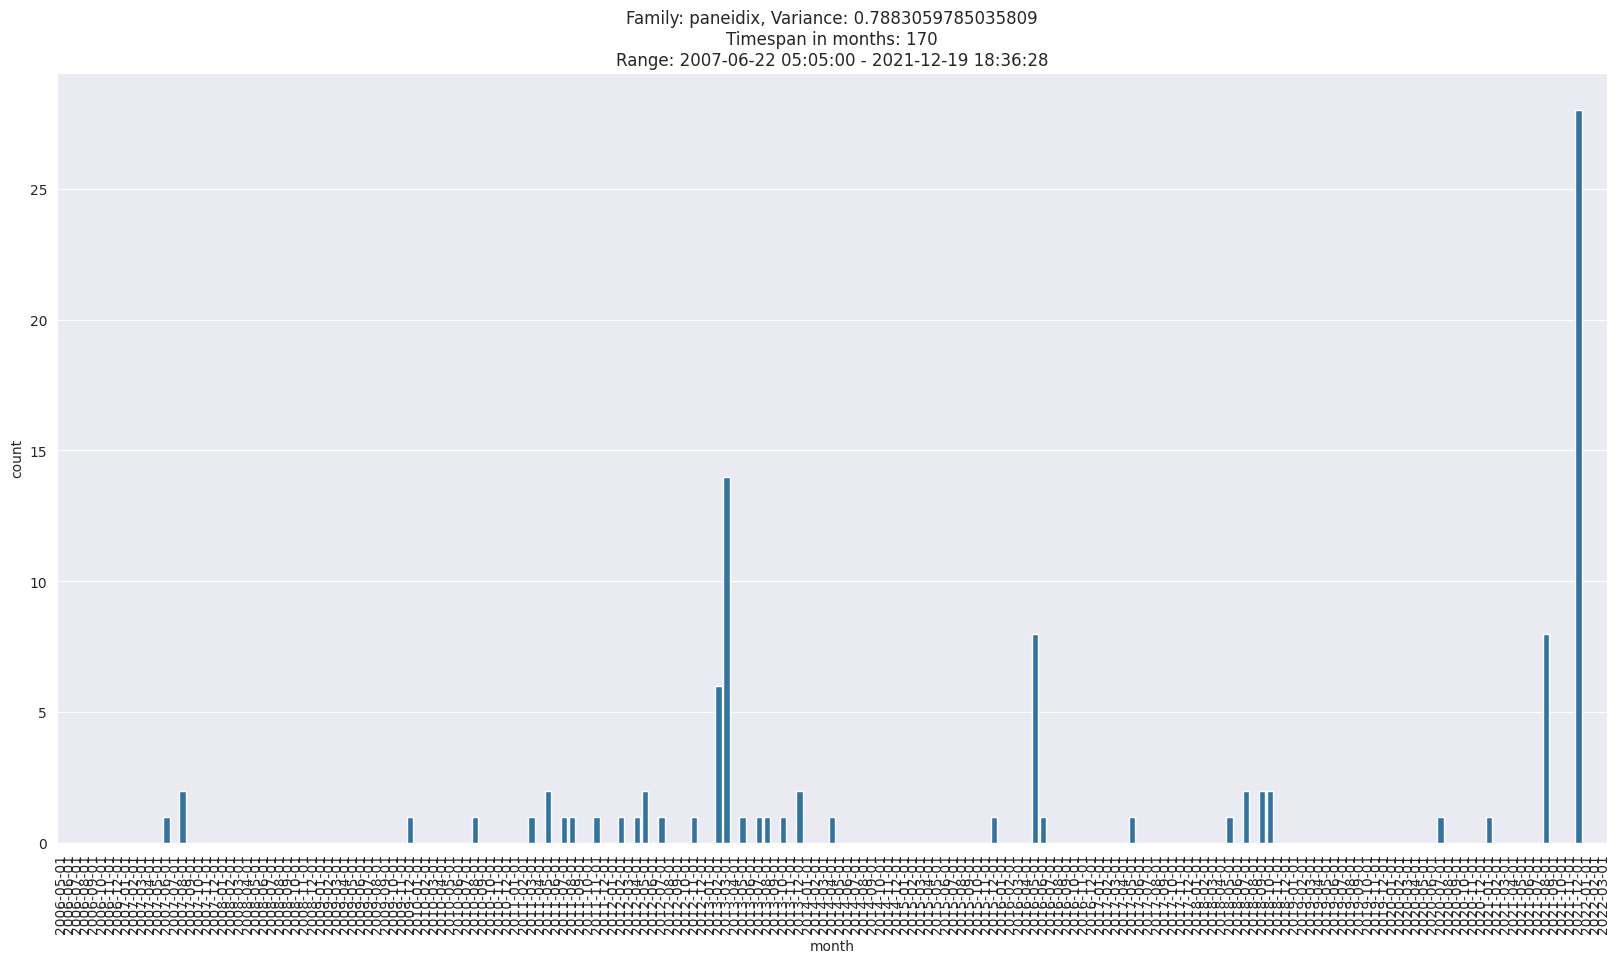

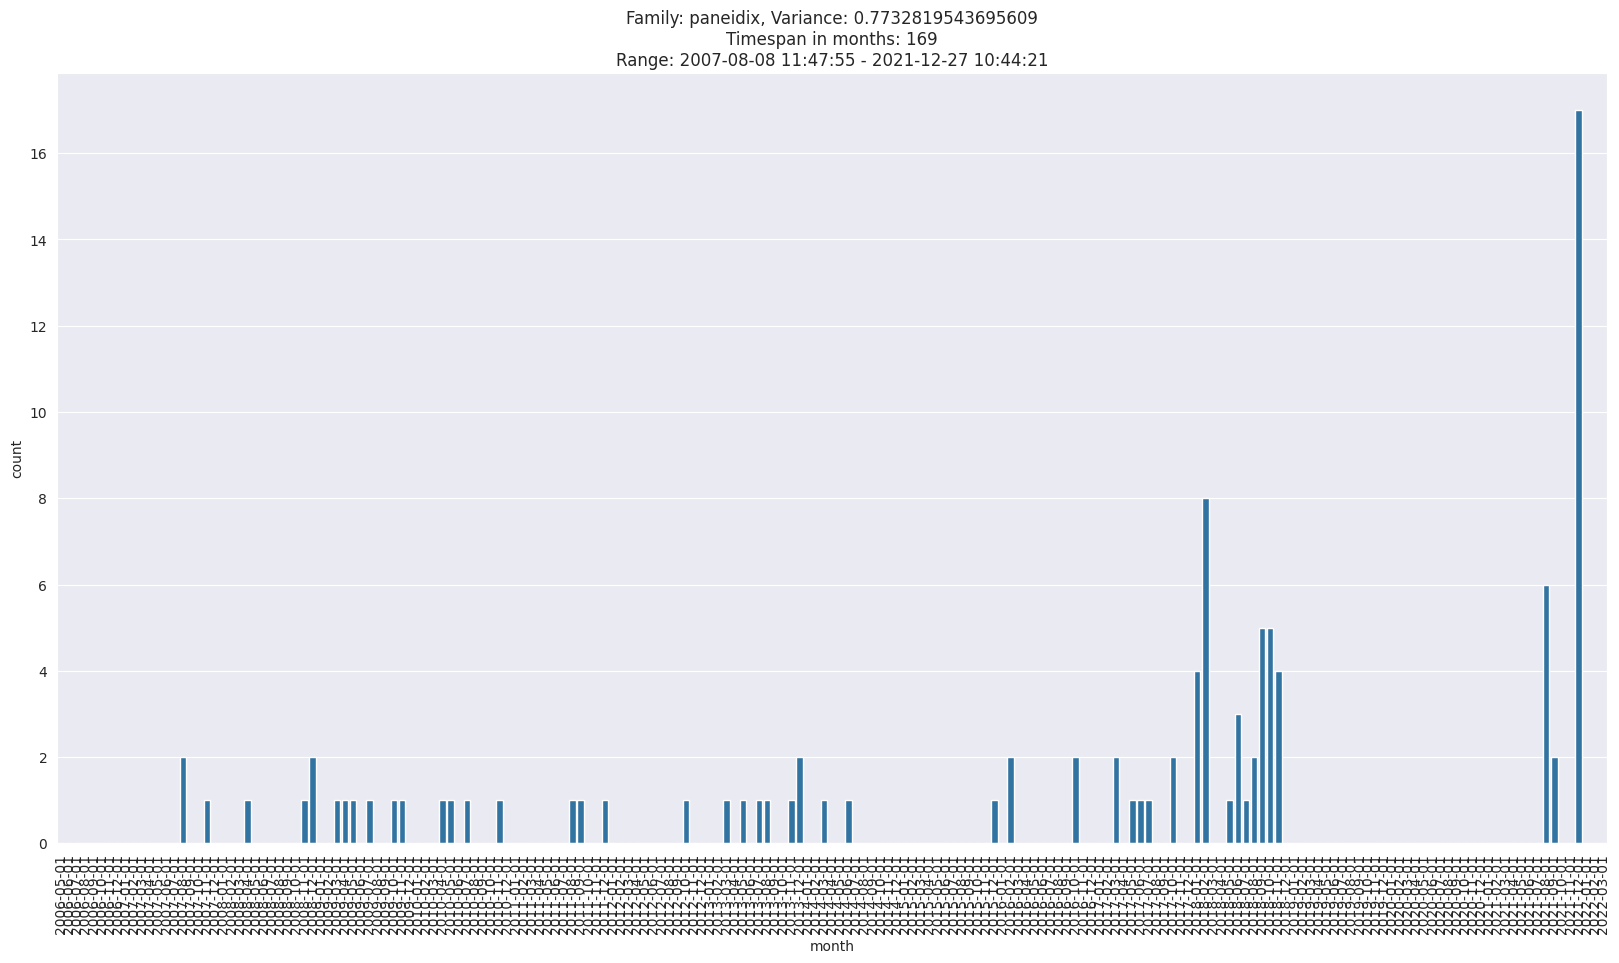

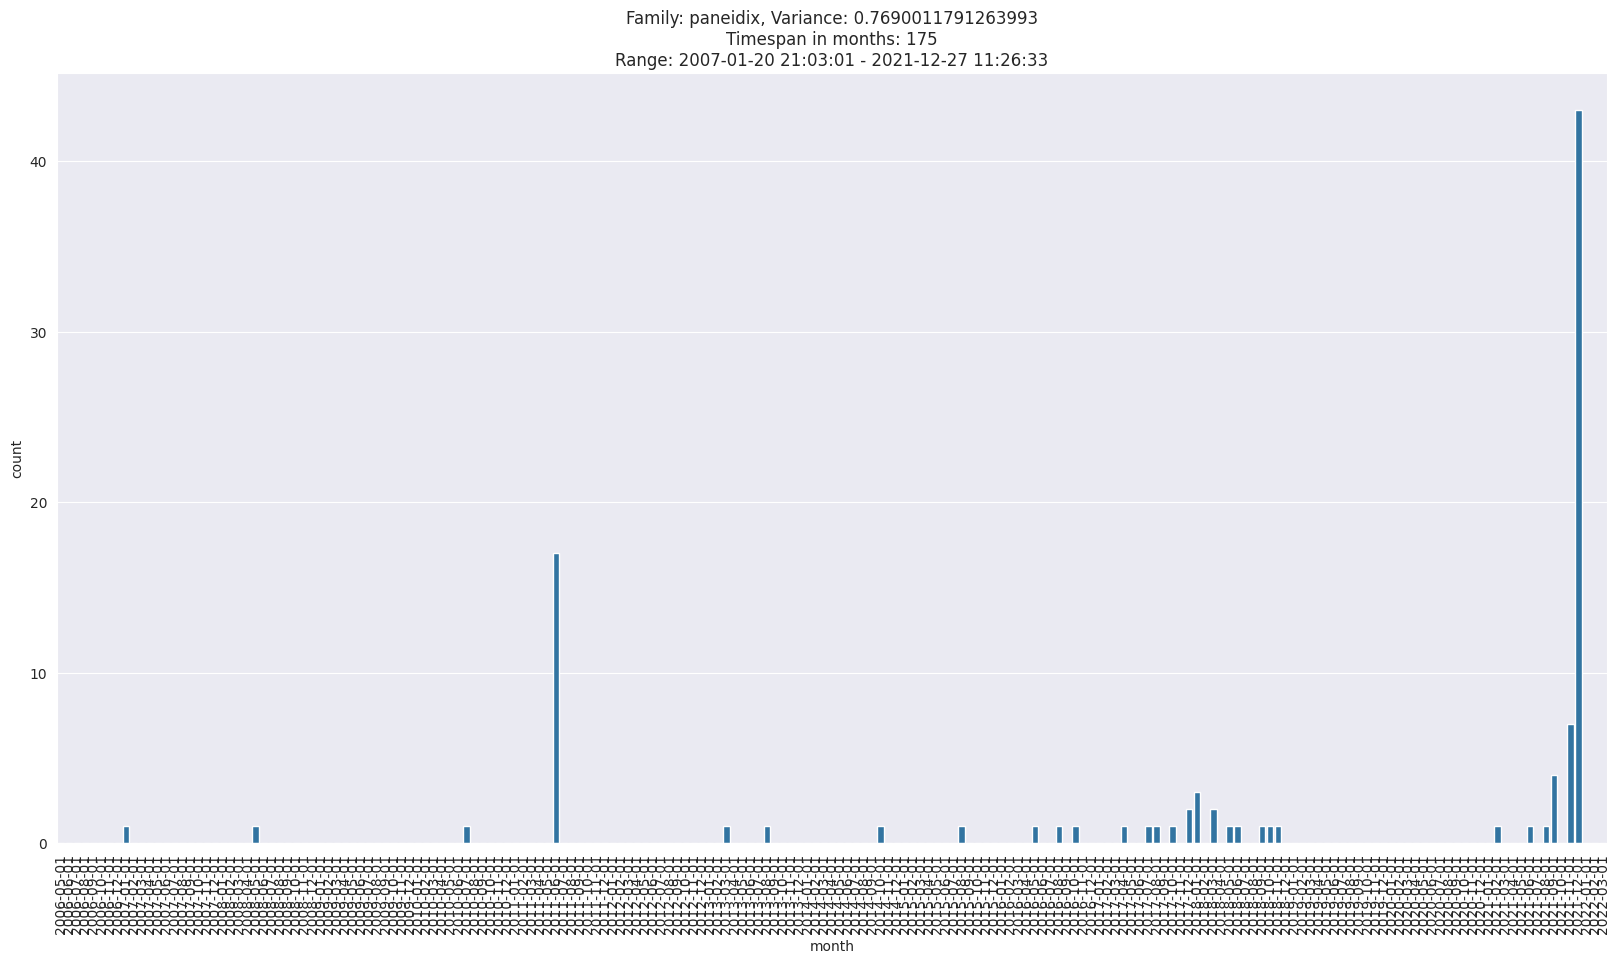

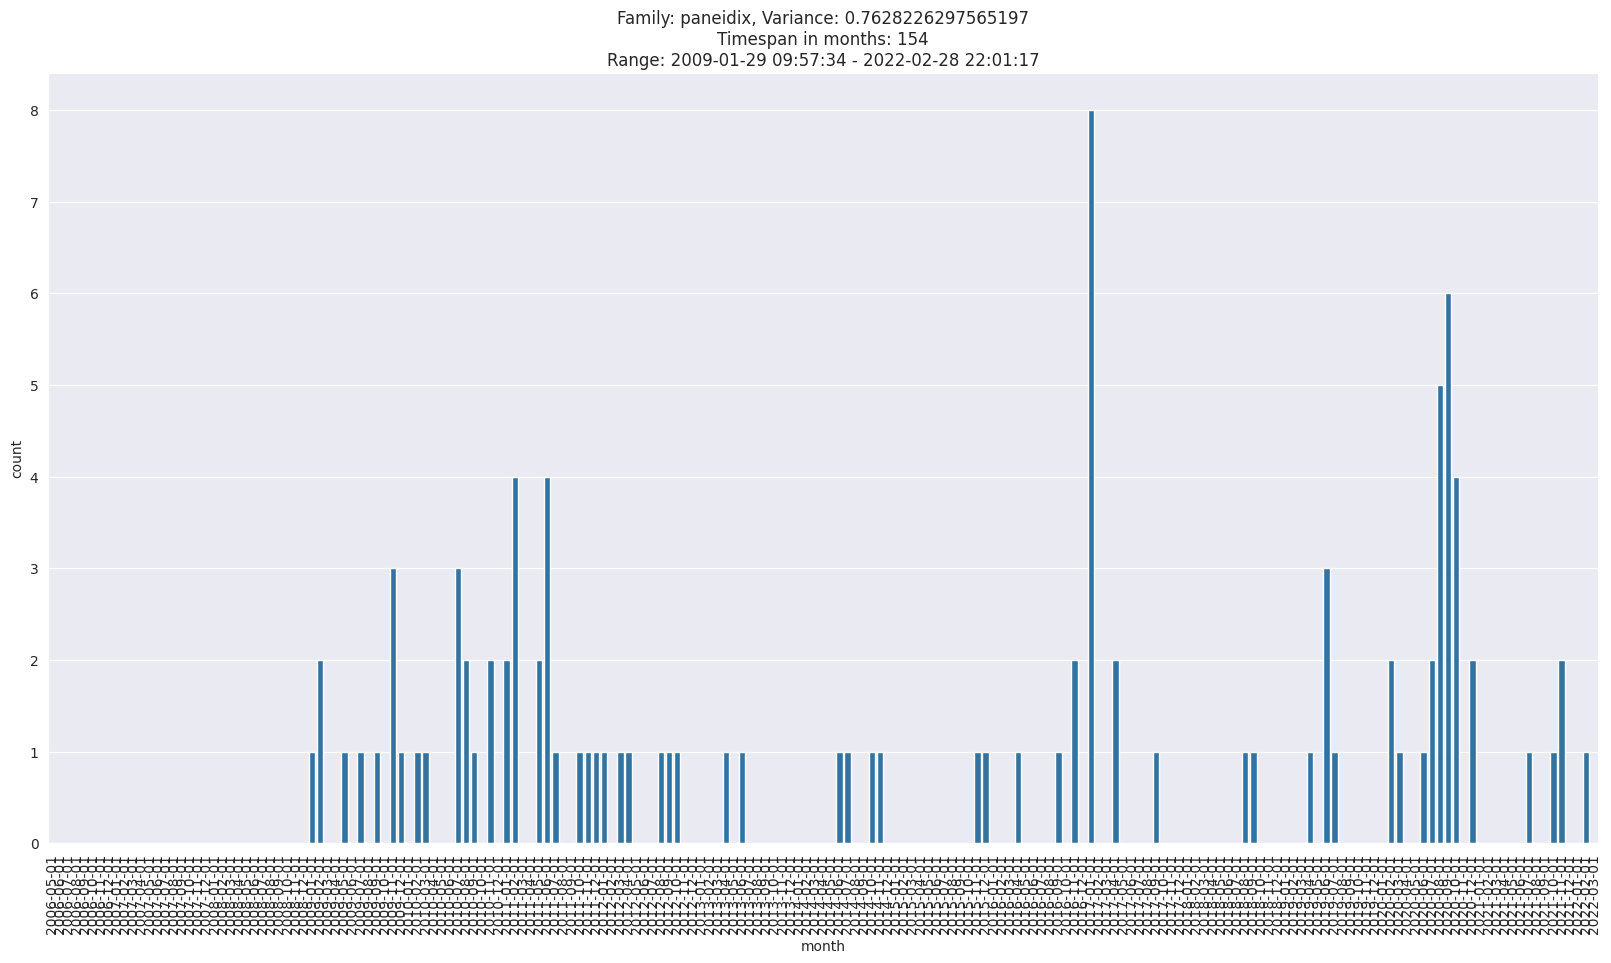

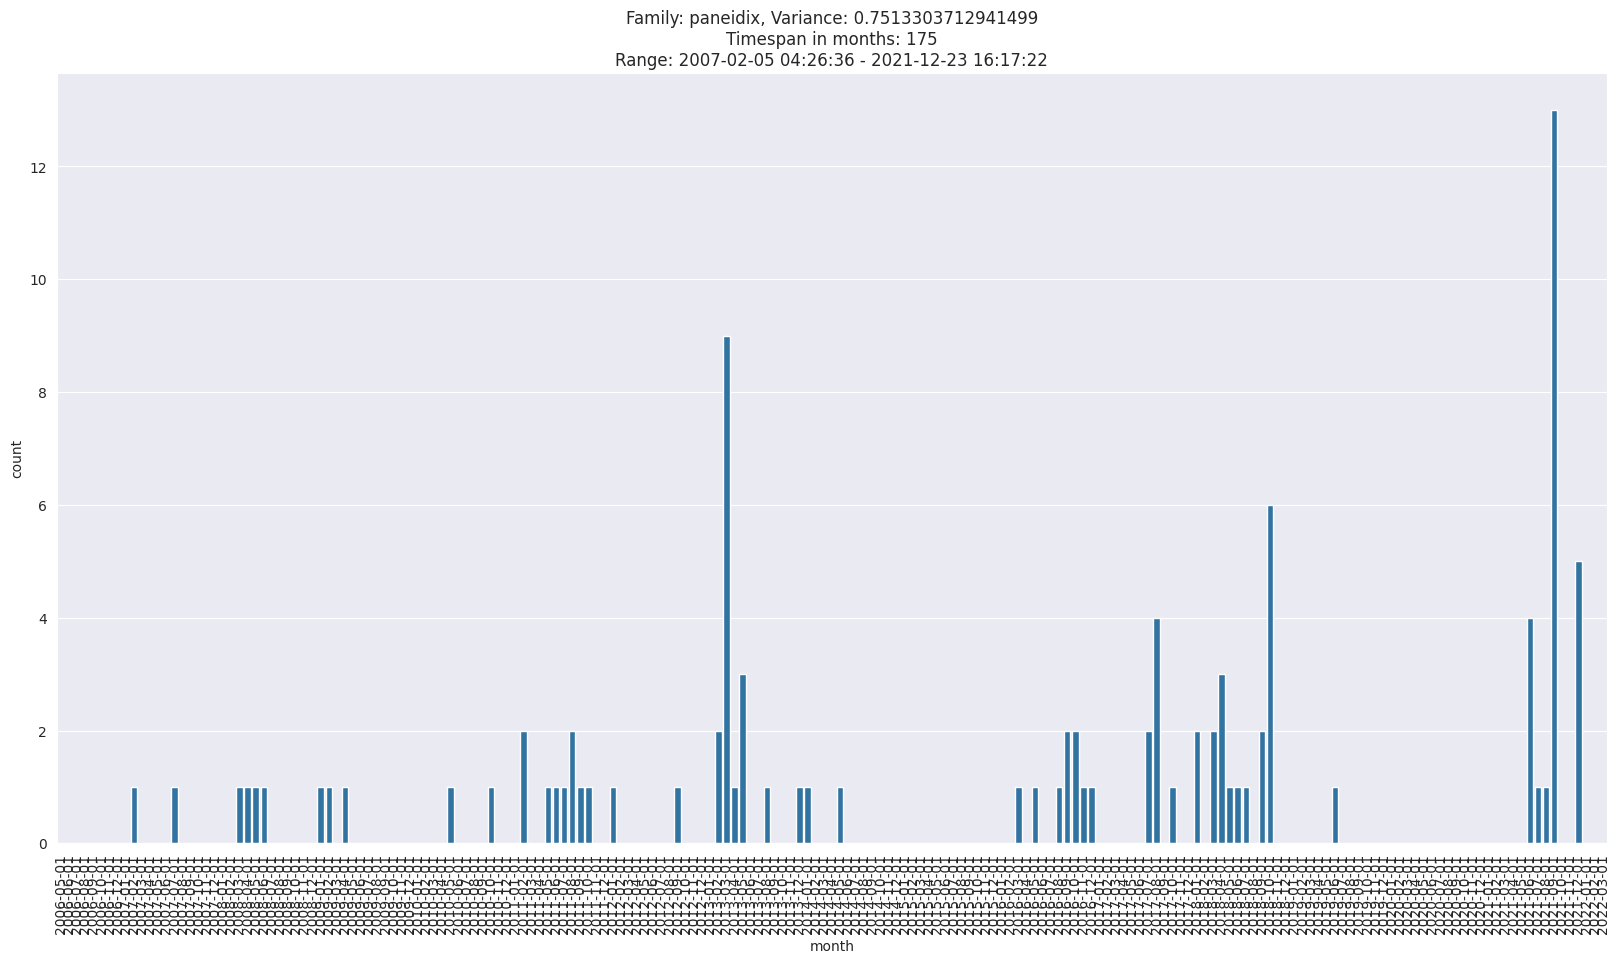

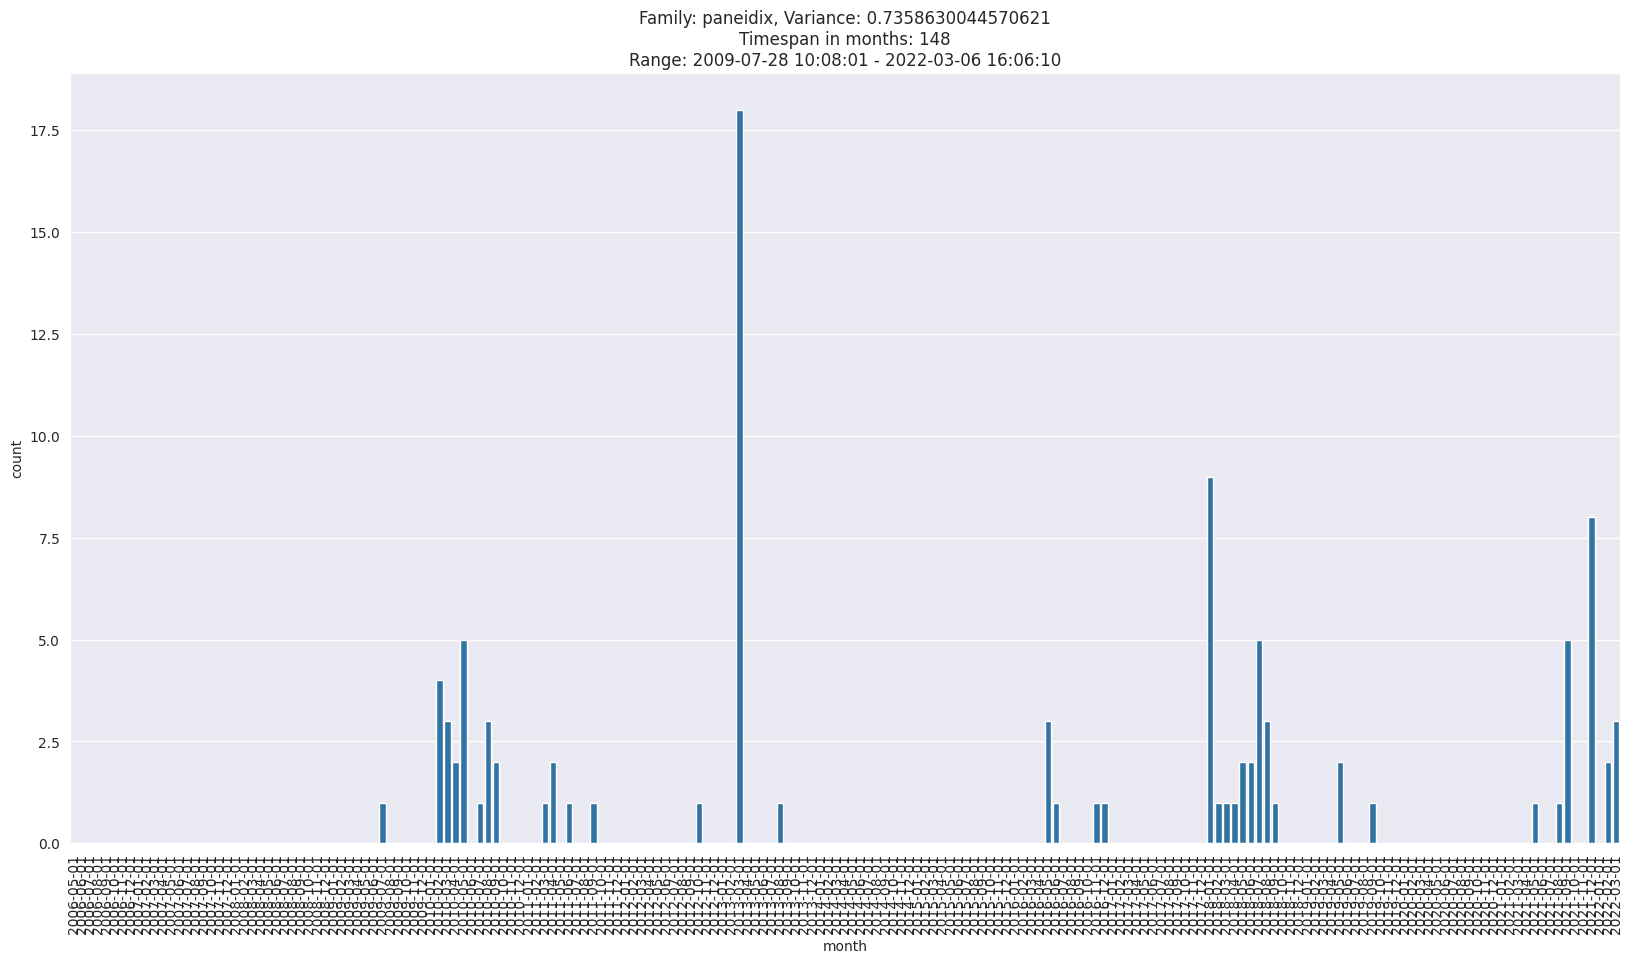

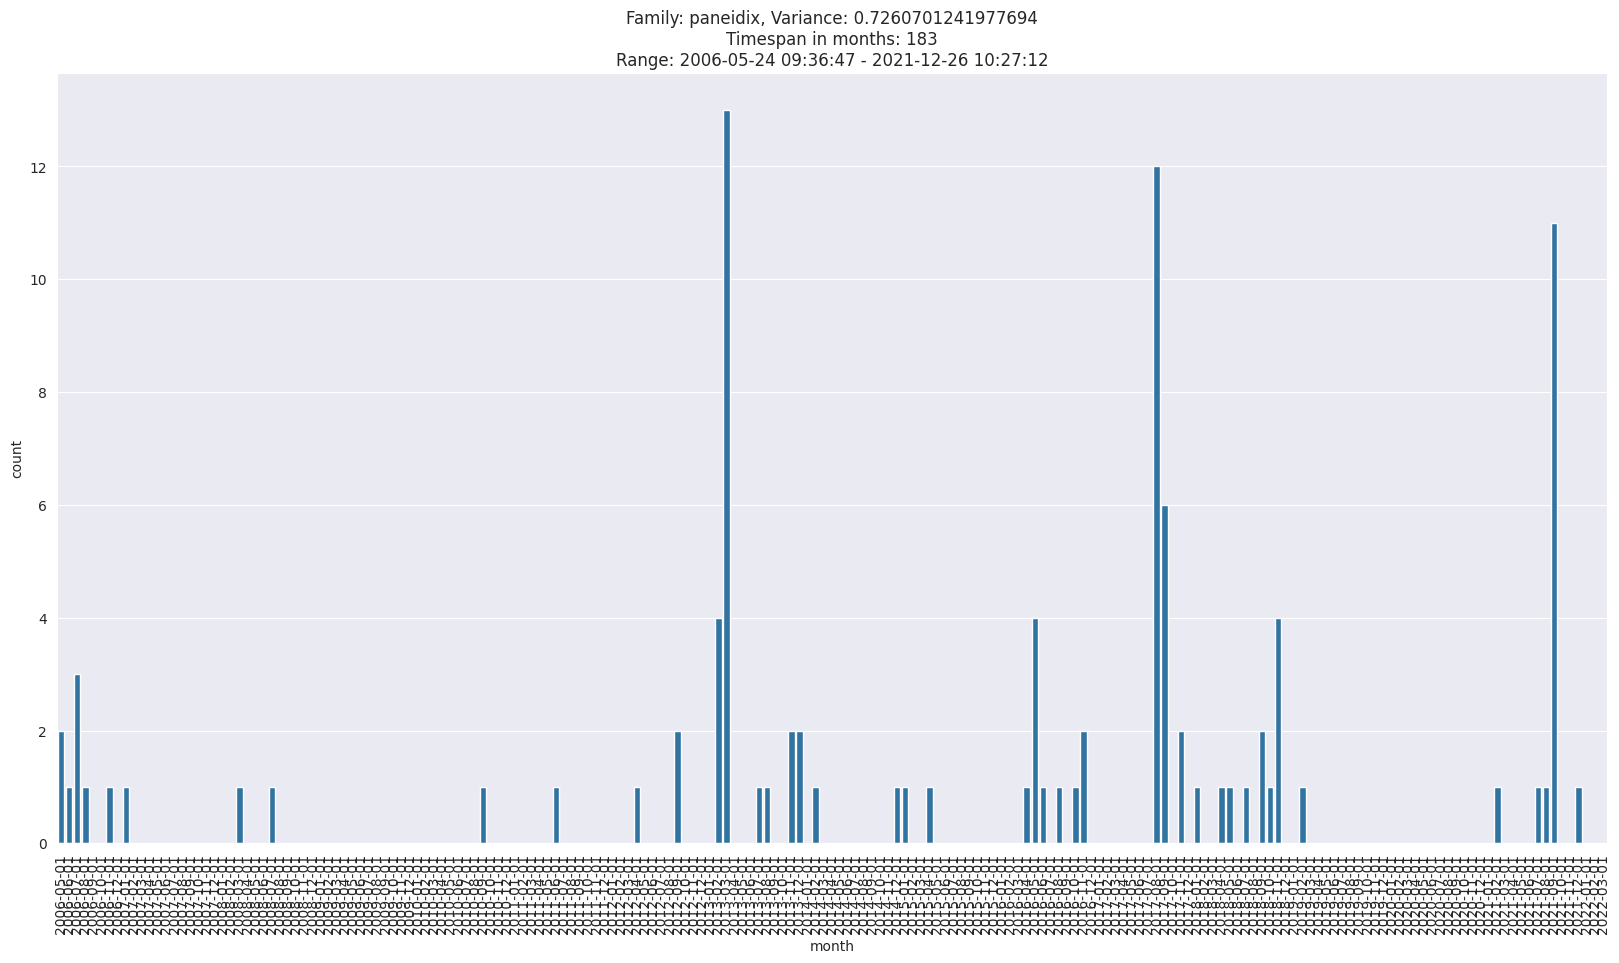

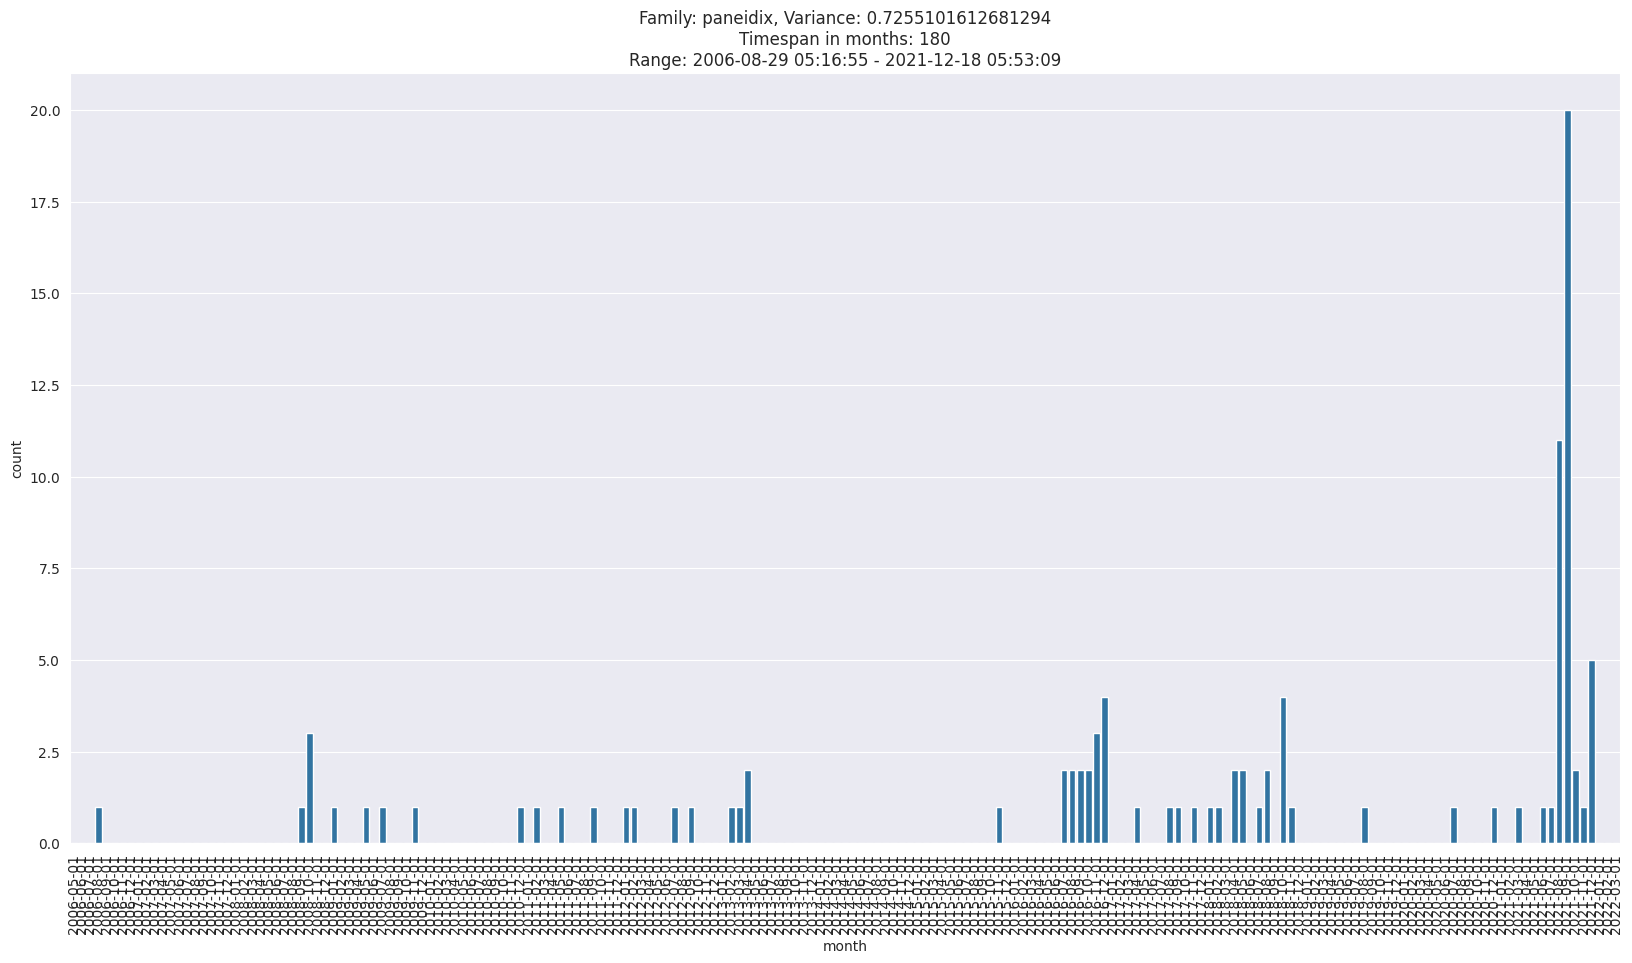

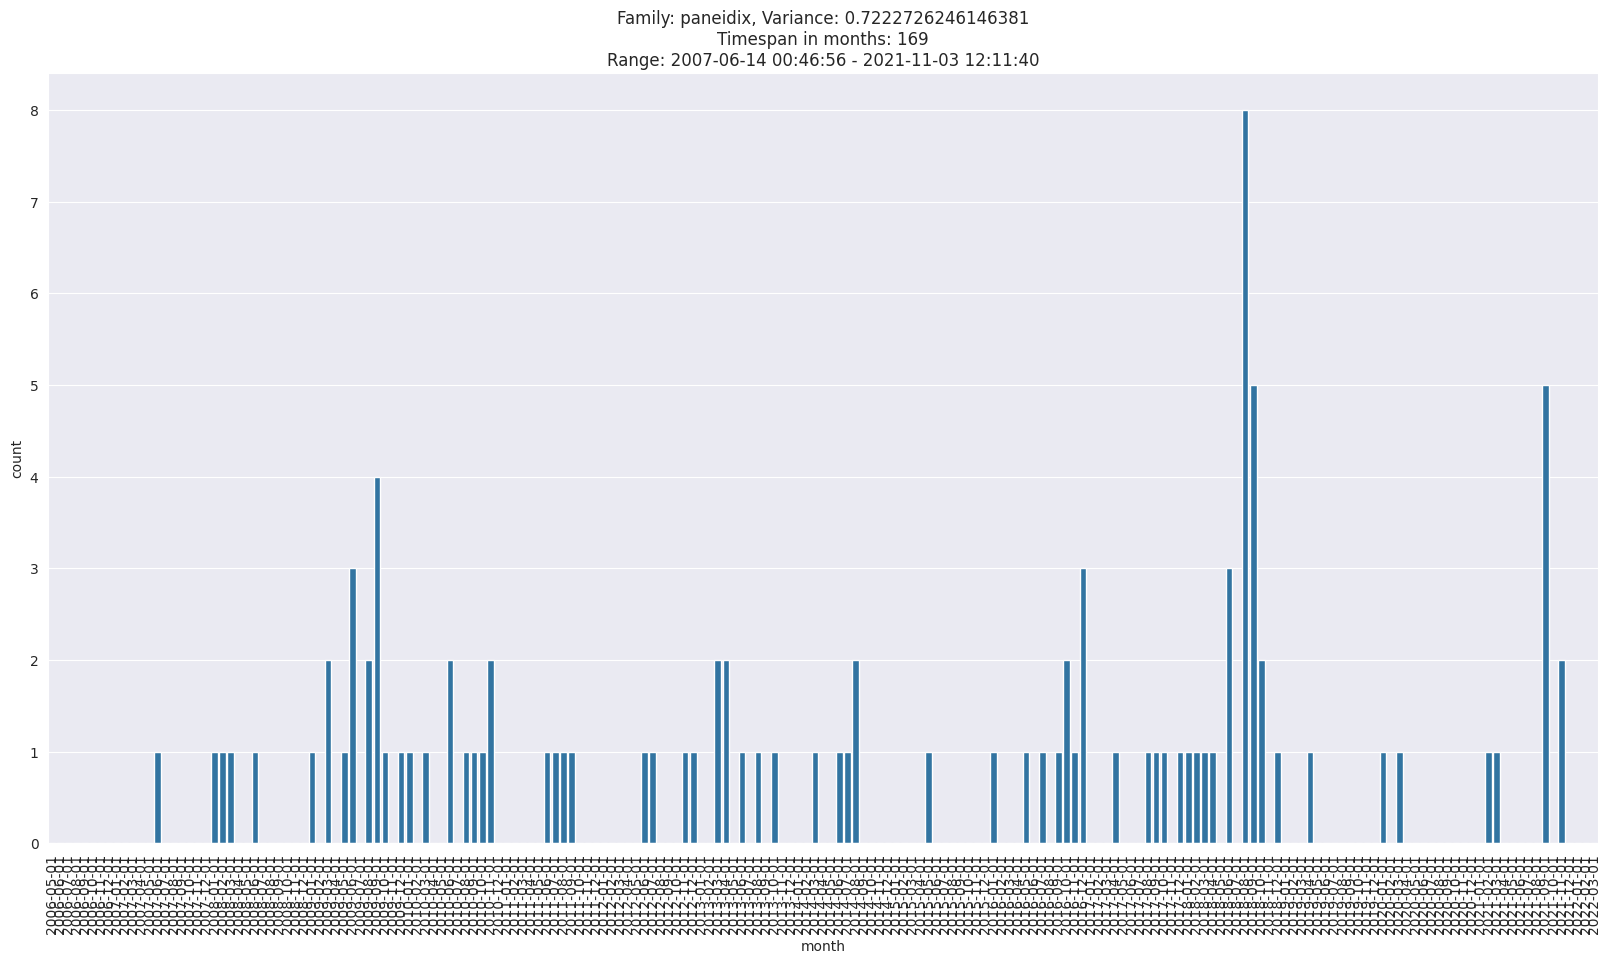

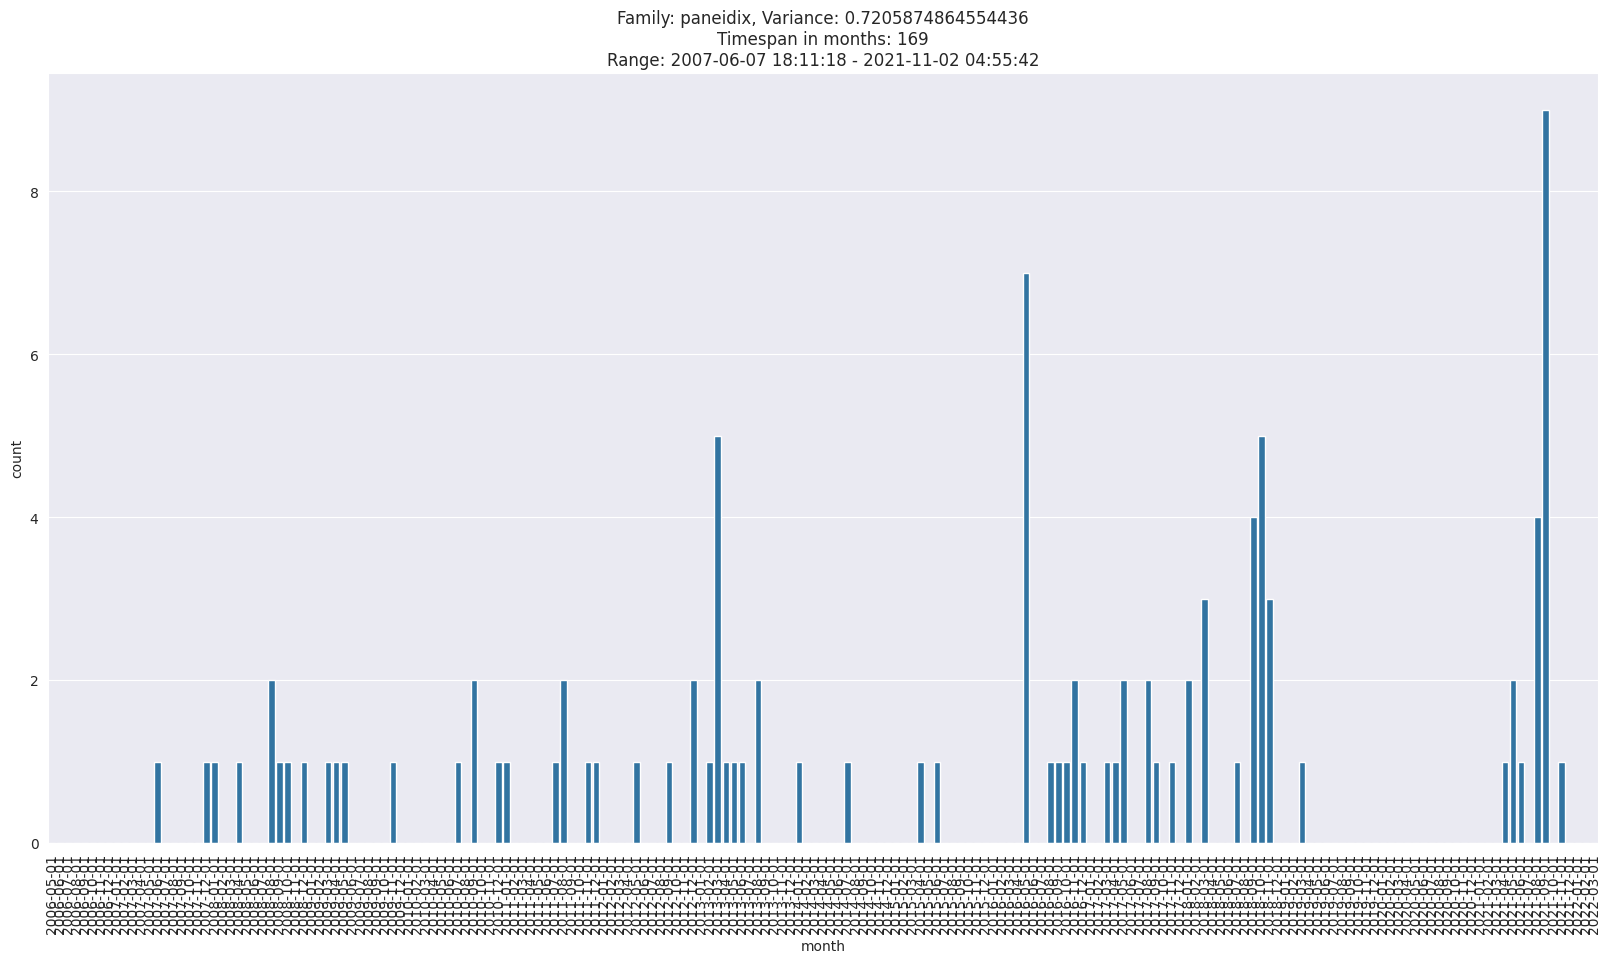

In [126]:
df_variances_desc = df_variances.sort_values(by="variance", ascending=False)
plot_family_distribution(df_variances_desc.head(20))